<a href="https://colab.research.google.com/github/NguyenThiHongLinh/TieuLuan2024/blob/main/Ti%E1%BB%83u_lu%E1%BA%ADn_Beijing_NF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Kết nối với drive, import thư viện

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd '/content/gdrive/MyDrive/Data tiểu luận'
! pip install pypots>=0.4

Mounted at /content/gdrive
/content/gdrive/MyDrive/Data tiểu luận


In [2]:
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.preprocessing import LabelEncoder
from datetime import datetime
from prettytable import PrettyTable
from numpy import mean
from numpy import std
# import miceforest as mf
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler
# from pypots.data import load_specific_dataset, mcar, masked_fill
import torch
from pypots.data import load_specific_dataset
from pypots.imputation import SAITS
from pypots.optim import Adam
from pypots.imputation import BRITS
from pypots.imputation import MRNN
from pypots.imputation import Transformer
from pypots.utils.metrics import calc_mae
from pypots.utils.metrics import calc_mse
from pypots.utils.metrics import calc_rmse

In [3]:
dtype = {
    "PM2.5": float,
    "PM10": float,
    "SO2": float,
    "NO2": float,
    "CO": float,
    "O3": float,
    "TEMP": float,
    "PRES": float,
    "DEWP": float,
    "RAIN": float,
    "wd": float,
    "WSPM": float,
    "station": str
}


def clean_data(elem):
    elem = str(elem)
    if elem == None or elem == '':
        return np.NaN
    if any(x in elem for x in ["#", "*", "x"]):
        return np.NaN
    if any(x in elem for x in [".", "e"]):
        return float(elem)
    if elem in 'NR':
        return -1
    return int(elem)

converters = {
    "PM2.5": clean_data,
    "PM10": clean_data,
    "SO2": clean_data,
    "NO2": clean_data,
    "CO": clean_data,
    "O3": clean_data,
    "TEMP": clean_data,
    "PRES": clean_data,
    "DEWP": clean_data,
    "RAIN": clean_data,
    "wd": clean_data,
    "WSPM": clean_data,
}

## Load dataset, tính toán % dữ liệu bị thiếu

In [4]:
def load_beijing():
  dataset = pd.read_csv('beijing_air_quality.csv', dtype = dtype, converters = converters, parse_dates = ['time'])
  dataset['time'] = pd.to_datetime(dataset['time'])
  return dataset

In [5]:
# Compute % missing rate of a given dataset (as a DataFrame)
def missing_rate(dataset):
  total_missing = dataset.isnull().sum().sum()
  percent_missing = (total_missing / dataset.size) * 100
  return round(percent_missing,2)

## Tiền xử lý dữ liệu

In [6]:
def preprocess_beijing(dataset):
    """The preprocessing function for dataset Air Quality Beijing.
    Parameters
    ----------
    dataset : raw dataset loaded from csv file.
    Returns
    -------
    dataset : pandas.DataFrame,
                A dataframe contains all time series vectors, distinguished by column 'station'.
    """
    print('Columns:', dataset.columns)

    # Giả sử dữ liệu ngày tháng nằm trong cột 'time', tách ngày và giờ
    if 'time' in dataset.columns:
        dataset['date'] = pd.to_datetime(dataset['time']).dt.date
        dataset['hour'] = pd.to_datetime(dataset['time']).dt.hour
    else:
        raise KeyError("'time' column not found in dataset")

    # Kiểm tra và bổ sung các ngày thiếu
    stations = dataset['station'].unique()
    full_date_range = pd.date_range(start=dataset['date'].min(), end=dataset['date'].max(), freq='D')

    df_list = []
    for station in stations:
        station_data = dataset[dataset['station'] == station]
        station_dates = station_data['date'].unique()
        missing_dates = set(full_date_range.date).difference(station_dates)

        for missing_date in missing_dates:
            missing_date_data = pd.DataFrame({
                'time': [pd.Timestamp(missing_date) + pd.Timedelta(hours=h) for h in range(24)],
                'station': station,
                'date': [missing_date] * 24,
                'hour': range(24)
            })
            station_data = pd.concat([station_data, missing_date_data], ignore_index=True)

        df_list.append(station_data)

    dataset = pd.concat(df_list, ignore_index=True)

    X = dataset
    print('X shape: ', X.shape)

    def apply_func(df_temp):  # pad and truncate to set the max length of samples as 24
        missing = list(set(range(0, 24)).difference(set(df_temp['hour'])))
        missing_part = pd.DataFrame({
            'time': [df_temp['time'].iloc[0].replace(hour=h) for h in missing],
            'hour': missing
        })
        df_temp = pd.concat(
            [df_temp, missing_part], ignore_index=False, sort=False
        )  # pad the sample's length to 24 if it doesn't have enough time steps
        df_temp = df_temp.set_index('time').sort_index().reset_index()
        df_temp = df_temp.iloc[:24]  # truncate
        return df_temp

    X = X.groupby(['station', 'date']).apply(apply_func)
    X = X.drop('hour', axis=1)
    X = X.drop('station', axis=1)
    X = X.drop('date', axis=1)
    X = X.reset_index()
    X = X.drop(["level_2"], axis=1)

    return X

## Biểu diễn dữ liệu bị thiếu

In [7]:
def display_missing_percent(dataset):
  total = dataset.isnull().sum().sort_values(ascending=False)
  percent = (dataset.isnull().sum()/dataset.isnull().count()).sort_values(ascending=False)
  missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
  f, ax = plt.subplots(figsize=(15, 6))
  # plt.xticks(rotation='90')
  sns.barplot(x=missing_data.index, y=missing_data['Percent'])
  plt.xlabel('Features', fontsize=15)
  plt.ylabel('Percent of missing values', fontsize=15)
  plt.title('Percent missing data by feature', fontsize=15)
  missing_data.head

## Lọc và sắp xếp các bản ghi theo từng khu vực

In [9]:
def get_stat_by_station(dataset):
    myTable = PrettyTable(["No.", "station", "#Records", "From date", "To date"])
    # Split dataframe by RecordID
    j = 1
    classification = list(dataset['station'].unique())
    for i in classification:
        pm1 = dataset[dataset['station'].isin([i])]
        # Format time to desired format (e.g., DD-MM-YYYY HH:MM:SS)
        formatted_start_time = pm1['time'].min().strftime('%d-%m-%Y %H:%M:%S')
        formatted_end_time = pm1['time'].max().strftime('%d-%m-%Y %H:%M:%S')

        myTable.add_row([j,
                         i,
                         format(pm1.shape[0], ','),
                         formatted_start_time,
                         formatted_end_time])
        j += 1
    return myTable

## Biểu đồ phân phối tần suất thời gian

In [10]:
def find_time_steps(data):
    data['time'] = pd.to_datetime(data['time'], errors='coerce')

    if data['time'].isnull().any():
        print("Có các giá trị không thể chuyển đổi sang datetime:")
        print(data[data['time'].isnull()])
        return

    # Tính chu kỳ giữa các bản ghi
    column_datetime1 = data['time']
    time_diffs = column_datetime1.diff().dt.total_seconds().dropna()
    cycle_seconds = time_diffs.mode().iloc[0]
    print("The cycle duration appears to be approximately", cycle_seconds, "seconds.")

    # Xác định xem thời gian được ghi lại trong 24 giờ hay 12 giờ
    time_difference = (column_datetime1.iloc[-1] - column_datetime1.iloc[0]).total_seconds()
    if time_difference > 12 * 3600:  # 12 hours * 3600 seconds/hour
        print("The time cycle appears to be 24 hours.")
    else:
        print("The time cycle appears to be 12 hours.")

    # Tìm giờ bị thiếu của từng station nếu có
    all_hours = set(range(24))
    data['date'] = data['time'].dt.date
    data['hour'] = data['time'].dt.hour

    stations = data['station'].unique()
    full_date_range = pd.date_range(start=data['date'].min(), end=data['date'].max(), freq='D')

    for station in stations:
        station_data = data[data['station'] == station]
        station_dates = station_data['date'].unique()
        missing_dates = set(full_date_range.date).difference(station_dates)

        missing_data = []
        for missing_date in missing_dates:
            missing_data.append((station, missing_date, list(all_hours)))

        for date, group in station_data.groupby('date'):
            hours_in_day = set(group['hour'])
            missing_hours = all_hours - hours_in_day
            if missing_hours:
                missing_data.append((station, date, sorted(missing_hours)))

        if missing_data:
            print(f"Station {station} is missing the following hours:")
            for station, date, missing_hours in missing_data:
                formatted_date = pd.Timestamp(date).strftime('%Y-%m-%d')
                formatted_hours = [f"{hour:02d}:00" for hour in missing_hours]
                print(f"Date {formatted_date} is missing hours: {formatted_hours}")
        else:
            print(f"Station {station} has no missing hours.")

In [11]:
# Danh sách các bộ dữ liệu và tên của chúng
def timeGraph(dataset):

# Khởi tạo figure
  plt.figure(figsize=(10, 6))

  # Lặp qua từng bộ dữ liệu và tên
  for dataset, time_column in dataset:
      # Chuyển đổi cột thời gian sang định dạng datetime
      time_data = pd.to_datetime(dataset[time_column])
      # Trích xuất giờ từ các đối tượng datetime
      hours = [time.hour for time in time_data]
      # Vẽ biểu đồ histogram
      plt.hist(hours, bins=24, edgecolor='black', alpha=0.5, label=time_column)

  # Thiết lập tiêu đề và nhãn trục
  plt.xlabel('Giờ')
  plt.ylabel('Số lượng')
  plt.title('Phân phối tần suất của dữ liệu thời gian')
  plt.xticks(range(0, 24))
  plt.grid(True)
  plt.legend()  # Hiển thị chú thích về tên của mỗi bộ dữ liệu
  plt.show()

## Tính trend, cycle của dữ liệu

In [12]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# Tính trend của tập dữ liệu khi loại bỏ các giá trị bị thiếu
def calculate_trend(data):
    # Xử lý giá trị NaN: Loại bỏ các dòng chứa giá trị NaN
    data_cleaned = data.dropna()

    # Loại bỏ các cột không cần thiết nếu tồn tại
    for col in ['time', 'station', 'Unnamed: 0', 'date']:
        if col in data_cleaned.columns:
            data_cleaned = data_cleaned.drop([col], axis=1)

    column_names = list(data_cleaned.columns)
    num_subplots = len(column_names)  # Số lượng subplot bằng số cột dữ liệu

    fig, axes = plt.subplots(num_subplots, 1, figsize=(10, 6*num_subplots))

    # Vẽ biểu đồ dữ liệu và đường trend cho từng thuộc tính
    for idx, col in enumerate(column_names):
        X = np.array(range(len(data_cleaned))).reshape(-1, 1)
        y = data_cleaned[col].values.reshape(-1, 1)

        # Khởi tạo và fit mô hình hồi quy tuyến tính
        model = LinearRegression()
        model.fit(X, y)

        # Vẽ dữ liệu
        axes[idx].plot(data_cleaned[col], label=col)
        # Vẽ trend line
        axes[idx].plot(model.predict(X), label=f'Trend of {col}', linestyle='--')

        axes[idx].set_xlabel('Index')
        axes[idx].set_ylabel('Value')
        axes[idx].set_title(f'Trend of {col}')
        axes[idx].legend(loc="best")

    plt.tight_layout()  # Đảm bảo không gian giữa các subplot
    plt.show()

In [13]:
import pandas as pd
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf
import matplotlib.pyplot as plt

def find_cycle(data, column, lags=50):
    """
    Hàm tính chu kỳ của dữ liệu chuỗi thời gian dựa trên hàm tự tương quan (ACF).

    Parameters:
    ----------
    data : pandas.DataFrame
        DataFrame chứa dữ liệu chuỗi thời gian.
    column : str
        Tên cột chứa dữ liệu chuỗi thời gian cần tính chu kỳ.
    lags : int, optional
        Số lượng độ trễ (lags) để tính toán ACF. Mặc định là 50.

    Returns:
    -------
    cycle : int
        Chu kỳ của dữ liệu chuỗi thời gian.
    """
    # Xóa các giá trị thiếu
    data_cleaned = data.dropna(subset=[column])

    # Tính toán ACF
    acf_values = acf(data_cleaned[column], nlags=lags)

    # Tìm độ trễ (lag) tại đó ACF đạt cực đại (bỏ qua độ trễ 0)
    cycle = np.argmax(acf_values[1:]) + 1

    # Vẽ biểu đồ ACF để trực quan hóa
    plot_acf(data_cleaned[column], lags=lags)
    plt.title(f'Autocorrelation Function for {column}')
    plt.show()

    return cycle

def find_cycles_for_all_columns(data, lags=50):
    """
    Hàm tính chu kỳ cho tất cả các cột trong DataFrame.

    Parameters:
    ----------
    data : pandas.DataFrame
        DataFrame chứa dữ liệu chuỗi thời gian.
    lags : int, optional
        Số lượng độ trễ (lags) để tính toán ACF. Mặc định là 50.

    Returns:
    -------
    cycles : dict
        Từ điển chứa chu kỳ của mỗi cột trong DataFrame.
    """
    cycles = {}
    for column in data.columns:
        if column == 'station' or not np.issubdtype(data[column].dtype, np.number):
            continue
        cycle = find_cycle(data, column, lags)
        cycles[column] = cycle
    return cycles

## Chuẩn bị dữ liệu bị thiếu nhân tạo

In [14]:
from pygrinder import mcar, masked_fill
# def generate_artifical_missing(data, missing_rate):
#   X = data.copy()
#   X_intact, X, missing_mask, indicating_mask = mcar(X, missing_rate) # hold out 10-80% observed values as ground truth
#   X = masked_fill(X, 1 - missing_mask, np.nan)
#   return X_intact, X, missing_mask, indicating_mask
def generate_artifical_missing(data, missing_rate):
    X_intact = data.copy()
    missing_mask = np.random.rand(*data.shape) < missing_rate
    indicating_mask = np.random.rand(*data.shape) < missing_rate
    data[missing_mask] = np.nan
    return X_intact, data, missing_mask, indicating_mask

In [15]:
# def prepare_train_val_test(train_data, val_data, test_data, missing_rate, n_steps):
#     # Ensure 'date' column exists
#     if 'date' not in train_data.columns:
#         if 'time' in train_data.columns:
#             train_data['date'] = pd.to_datetime(train_data['time']).dt.date
#             val_data['date'] = pd.to_datetime(val_data['time']).dt.date
#             test_data['date'] = pd.to_datetime(test_data['time']).dt.date
#         else:
#             raise KeyError("Neither 'date' nor 'time' column exists in the data.")

#     num_samples = int(len(train_data['date']) / n_steps)

#     # Drop 'date' and 'station' columns
#     train_X = train_data.drop(['date', 'station'], axis=1)
#     val_X = val_data.drop(['date', 'station'], axis=1)
#     test_X = test_data.drop(['date', 'station'], axis=1)

#     train_X, val_X, test_X = (
#         train_X.to_numpy(),
#         val_X.to_numpy(),
#         test_X.to_numpy(),
#     )

#     # Normalize the data
#     scaler = StandardScaler()
#     train_X = scaler.fit_transform(train_X)
#     val_X = scaler.transform(val_X)
#     test_X = scaler.transform(test_X)

#     train_X = train_X.reshape(num_samples, n_steps, -1)
#     val_X = val_X.reshape(int(len(val_data['date']) / n_steps), n_steps, -1)
#     test_X = test_X.reshape(int(len(test_data['date']) / n_steps), n_steps, -1)

#     # Generate artificial missing data
#     val_X_intact, val_X, val_missing_mask, val_X_indicating_mask = generate_artifical_missing(val_X, missing_rate=missing_rate)
#     test_X_intact, test_X, test_missing_mask, test_X_indicating_mask = generate_artifical_missing(test_X, missing_rate=missing_rate)

#     data = {
#         "n_steps": n_steps,
#         "n_features": train_X.shape[-1],
#         "train_X": train_X,
#         "val_X": val_X,
#         "test_X": test_X,
#         "scaler": scaler,
#         "val_X_intact": val_X_intact,
#         "val_X_indicating_mask": val_X_indicating_mask,
#         "test_X_intact": test_X_intact,
#         "test_X_indicating_mask": test_X_indicating_mask,
#     }

#     return data

def prepare_train_val_test(train_data, val_data, test_data, missing_rate, n_steps):
    # Ensure 'date' column exists
    if 'date' not in train_data.columns:
        if 'time' in train_data.columns:
            train_data['date'] = pd.to_datetime(train_data['time']).dt.date
            val_data['date'] = pd.to_datetime(val_data['time']).dt.date
            test_data['date'] = pd.to_datetime(test_data['time']).dt.date
        else:
            raise KeyError("Neither 'date' nor 'time' column exists in the data.")

    # Drop 'date', 'station' and 'time' columns
    train_X = train_data.drop(['date', 'station', 'time'], axis=1)
    val_X = val_data.drop(['date', 'station', 'time'], axis=1)
    test_X = test_data.drop(['date', 'station', 'time'], axis=1)

    # Check for NaN values and remove rows with NaNs
    train_X = train_X.dropna()
    val_X = val_X.dropna()
    test_X = test_X.dropna()

    train_X, val_X, test_X = (
        train_X.to_numpy(),
        val_X.to_numpy(),
        test_X.to_numpy(),
    )

    # Normalize the data
    scaler = StandardScaler()
    train_X = scaler.fit_transform(train_X)
    val_X = scaler.transform(val_X)
    test_X = scaler.transform(test_X)

    # Calculate the number of samples
    num_samples_train = train_X.shape[0] // n_steps
    num_samples_val = val_X.shape[0] // n_steps
    num_samples_test = test_X.shape[0] // n_steps

    # Reshape the arrays
    train_X = train_X[:num_samples_train * n_steps].reshape(num_samples_train, n_steps, -1)
    val_X = val_X[:num_samples_val * n_steps].reshape(num_samples_val, n_steps, -1)
    test_X = test_X[:num_samples_test * n_steps].reshape(num_samples_test, n_steps, -1)

    # Generate artificial missing data
    val_X_intact, val_X, val_missing_mask, val_X_indicating_mask = generate_artifical_missing(val_X, missing_rate=missing_rate)
    test_X_intact, test_X, test_missing_mask, test_X_indicating_mask = generate_artifical_missing(test_X, missing_rate=missing_rate)

    data = {
        "n_steps": n_steps,
        "n_features": train_X.shape[-1],
        "train_X": train_X,
        "val_X": val_X,
        "test_X": test_X,
        "scaler": scaler,
        "val_X_intact": val_X_intact,
        "val_X_indicating_mask": val_X_indicating_mask,
        "test_X_intact": test_X_intact,
        "test_X_indicating_mask": test_X_indicating_mask,
    }

    return data

## Chia dữ liệu thành tập train, val, test

In [16]:
def split_train_test_beijing(dataset):
  date_format = '%Y-%m-%d %H:%M:%S'
  # train_start = datetime.strptime('2015-01-01 00:00:00', date_format)
  train_end = datetime.strptime('2015-8-31 23:00:00', date_format)
  val_end = datetime.strptime('2015-10-31 23:00:00', date_format)
  # tỉ lệ 60/20/20
  # train_end = datetime.strptime('2015-12-15 23:00:00', date_format)
  # val_end = datetime.strptime('2016-12-8 23:00:00', date_format)

  # test_end = datetime.strptime('2015-12-31 23:00:00', date_format)


# group by station
  classification=list(dataset['station'].unique())
  train_data = pd.DataFrame()
  val_data = pd.DataFrame()
  test_data = pd.DataFrame()
  for i in classification:
    pm1=dataset[dataset['station'].isin([i])]
    # Split the data into training, validation, and test sets
    train_data = pd.concat([train_data, pm1[pm1.time <= train_end]])
    val_data = pd.concat([val_data, pm1[(train_end < pm1.time) & (pm1.time <= val_end)]])
    test_data = pd.concat([test_data, pm1[pm1.time > val_end]])
  train_data.sort_values(['station', 'time'])
  val_data.sort_values(['station', 'time'])
  test_data.sort_values(['station', 'time'])
  return train_data, val_data, test_data

## Chia tập trai, test, val cho các phương thức sử dụng PyPots

In [17]:
def get_train_val_test_pypots(data):
  dataset_for_training = {
    "X": data['train_X'],
  }

  dataset_for_validating = {
    "X": data['val_X'],
    "X_ori": data['val_X_intact'],
    "indicating_mask": data['val_X_indicating_mask'],
  }

  dataset_for_testing = {
    "X": data['test_X'],
  }
  return dataset_for_training, dataset_for_validating, dataset_for_testing

# def get_train_val_test_pypots(data):
#     # Convert the data from numpy arrays to PyPOTS dataset format
#     train_X = data["train_X"]
#     val_X = data["val_X"]
#     test_X = data["test_X"]

#     # Prepare the masks (1 for missing values, 0 for observed values)
#     train_mask = np.isnan(train_X).astype(int)
#     val_mask = np.isnan(val_X).astype(int)
#     test_mask = np.isnan(test_X).astype(int)

#     # Replace NaNs with a placeholder value for the model input
#     train_X_placeholder = np.nan_to_num(train_X, nan=0)
#     val_X_placeholder = np.nan_to_num(val_X, nan=0)
#     test_X_placeholder = np.nan_to_num(test_X, nan=0)

#     # Create datasets for training, validation, and testing
#     dataset_for_training = {'X': train_X_placeholder, 'X_ori': train_X, 'mask': train_mask}
#     dataset_for_validating = {'X': val_X_placeholder, 'X_ori': val_X, 'mask': val_mask}
#     dataset_for_testing = {'X': test_X_placeholder, 'X_ori': test_X, 'mask': test_mask}

#     return dataset_for_training, dataset_for_validating, dataset_for_testing

# Phương pháp truyền thống

##Phương pháp Median

In [18]:
def imputeByMedian(data):
  X = data['test_X']
  X = X.reshape(X.shape[0], -1)
  start = time.time()*1000 #in milliseconds
  X[np.isnan(X)] = np.nanmedian(X)
  running_time = (time.time()*1000 - start)
  X = X.reshape(X.shape[0], data['n_steps'], -1)
  return X, running_time

## Phương pháp Mean

In [19]:
def imputeByMean(data):
  X = data['test_X']
  X = X.reshape(X.shape[0], -1)
  start = time.time()*1000 #in milliseconds
  X[np.isnan(X)] = np.nanmean(X)
  running_time = (time.time()*1000 - start)
  X = X.reshape(X.shape[0], data['n_steps'], -1)
  return X, running_time

## Phương pháp kNN

In [20]:
def imputeByKNN(data):
  train_X = data['train_X']
  train_X = train_X.reshape(train_X.shape[0], -1)
  test_X = data['test_X']
  test_X = test_X.reshape(test_X.shape[0], -1)
  start = time.time()*1000 #in milliseconds
  knn_imputer = KNNImputer(n_neighbors=3, weights="uniform")
  knn_imputer.fit(train_X)
  X_imputed = knn_imputer.transform(test_X)
  running_time = (time.time()*1000 - start)
  X_imputed = X_imputed.reshape(X_imputed.shape[0], data['n_steps'], -1)
  return X_imputed, running_time

## Phương pháp MICE

In [21]:
def imputeByMICE(data):
  train_X = data['train_X']
  train_X = train_X.reshape(train_X.shape[0], -1)
  test_X = data['test_X']
  test_X = test_X.reshape(test_X.shape[0], -1)
  start = time.time()*1000 #in milliseconds
  mice_imputer = IterativeImputer(max_iter=5, verbose=1)
  mice_imputer.fit(train_X)
  X_imputed = mice_imputer.transform(test_X)
  running_time = (time.time()*1000 - start)
  X_imputed = X_imputed.reshape(X_imputed.shape[0], data['n_steps'], -1)
  return X_imputed, running_time

# Phương pháp dựa trên mạng neural

## Phương pháp SAITS

In [35]:
# # https://github.com/WenjieDu/SAITS
# # Model training. This is PyPOTS showtime. 💪
def apply_saits(data): #data: dict generated from prepare_train_val_test
  saits = SAITS(n_steps=data['n_steps'], n_features=data['n_features'], n_layers=2, d_model=256,d_ffn=128,
                 n_heads=4, d_k=64, d_v=64, dropout=0.1, epochs=15, patience=3, device='cpu', saving_path="data_beijing/saits")
  dataset_for_training, dataset_for_validating, dataset_for_testing = get_train_val_test_pypots(data)

  start = time.time()*1000 #in milliseconds
  # saits.fit(dataset)  # train the model. Here I use the whole dataset as the training set, because ground truth is not visible to the model.
  saits.fit(train_set=dataset_for_training, val_set=dataset_for_validating)
  imputation = saits.impute(dataset_for_testing)  # impute the originally-missing values and artificially-missing values
  running_time = (time.time()*1000 - start)
  return imputation, running_time

# def apply_saits(data):  # data: dict generated from prepare_train_val_test
#     # Initialize the SAITS model with the required parameters
#     saits = SAITS(n_steps=data['n_steps'], n_features=data['n_features'], n_layers=2, d_model=256,
#                   d_ffn=128, n_heads=4, d_k=64, d_v=64, dropout=0.1, epochs=15, patience=3, device='cpu', saving_path="data/saits_beijing",)

#     # Prepare the training, validation, and testing datasets
#     dataset_for_training, dataset_for_validating, dataset_for_testing = get_train_val_test_pypots(data)

#     start = time.time() * 1000  # Start timing (in milliseconds)

#     # Train the model
#     saits.fit(train_set=dataset_for_training, val_set=dataset_for_validating)

#     # Impute the originally-missing values and artificially-missing values
#     imputation = saits.impute(dataset_for_testing)

#     running_time = time.time() * 1000 - start  # Calculate running time

#     return imputation, running_time

## Phương pháp MRNN

In [36]:
# https://github.com/WenjieDu/SAITS
# Model training. This is PyPOTS showtime. 💪
def apply_mrnn(data): #data: dict generated from prepare_train_val_test
  mrnn = MRNN(n_steps=data['n_steps'], n_features=data['n_features'], rnn_hidden_size=128,
    batch_size=32, epochs=15, patience=3, optimizer=Adam(lr=1e-3),
    num_workers=0, device='cpu',
    saving_path="data_beijing/mrnn",
    # model_saving_strategy="best",
  )
  dataset_for_training, dataset_for_validating, dataset_for_testing = get_train_val_test_pypots(data)

  start = time.time()*1000 #in milliseconds
  mrnn.fit(train_set=dataset_for_training, val_set=dataset_for_validating)
  imputation = mrnn.impute(dataset_for_testing)  # impute the originally-missing values and artificially-missing values
  running_time = (time.time()*1000 - start)
  return imputation, running_time

# Tổng hợp các phương pháp

In [24]:
def export_metrics(imputation, X_intact, indicating_mask):
  mae = calc_mae(imputation, X_intact, indicating_mask)
  mse = calc_mse(imputation, X_intact, indicating_mask)
  rmse = calc_rmse(imputation, X_intact, indicating_mask)
  return mae, mse, rmse

In [25]:
# def impute_missing(train_data, val_data, test_data, method, rate, n_steps, compute_metrics=True):
#   data = prepare_train_val_test(train_data, val_data, test_data, missing_rate=rate, n_steps=n_steps)
#   if method == 'mean':
#     imputation, running_time = imputeByMean(data)
#   elif method == 'median':
#     imputation, running_time = imputeByMedian(data)
#   elif method == 'knn':
#     imputation, running_time  = imputeByKNN(data)
#   elif method == 'mice':
#     imputation, running_time = imputeByMICE(data)
#   else:
#     raise Exception("Sorry, method is unsupported!")
#   result = {
#       "imputation": imputation,
#       "running_time": running_time,
#       "scaler": data['scaler'],
#     }
#   if(compute_metrics == True):
#     mae, mse, rmse = export_metrics(imputation, data['test_X_intact'], data['test_X_indicating_mask'])
#     result["mae"] = mae
#     result["mse"] = mse
#     result["rmse"] = rmse
#   return result

def impute_missing(train_data, val_data, test_data, method, rate, n_steps, compute_metrics=True):
    data = prepare_train_val_test(train_data, val_data, test_data, missing_rate=rate, n_steps=n_steps)
    if method == 'mean':
        imputation, running_time = imputeByMean(data)
    elif method == 'median':
        imputation, running_time = imputeByMedian(data)
    elif method == 'knn':
        imputation, running_time  = imputeByKNN(data)
    elif method == 'mice':
        imputation, running_time = imputeByMICE(data)
    elif method == 'mrnn':
        imputation, running_time = apply_mrnn(data)
    elif method == 'saits':
        imputation, running_time = apply_saits(data)
    else:
        raise Exception("Sorry, method is unsupported!")
    result = {
        "imputation": imputation,
        "running_time": running_time,
        "scaler": data['scaler'],
    }
    if compute_metrics:
        mae, mse, rmse = export_metrics(imputation, data['test_X_intact'], data['test_X_indicating_mask'])
        result["mae"] = mae
        result["mse"] = mse
        result["rmse"] = rmse
    return result

In [37]:
# def run_experiment(dataset, missing_rates, methods, n_steps=24, N=10):
#     # Generate dataframe columns
#     COLUMN_NAMES = ["Artificial missing rate"]
#     for method in methods:
#         COLUMN_NAMES.extend([method, method+'_STD'])

#     df_mae = pd.DataFrame(columns=COLUMN_NAMES)
#     df_mse = pd.DataFrame(columns=COLUMN_NAMES)
#     df_rmse = pd.DataFrame(columns=COLUMN_NAMES)
#     df_running_time = pd.DataFrame(columns=COLUMN_NAMES)

#     # Ensure 'date' column exists
#     if 'date' not in dataset.columns:
#         if 'time' in dataset.columns:
#             dataset['date'] = pd.to_datetime(dataset['time']).dt.date
#         else:
#             raise KeyError("Neither 'date' nor 'time' column exists in the dataset.")

#     train_data, val_data, test_data = split_train_test_taiwan2015(dataset)

#     for rate in missing_rates:
#         list_rate_mae = [rate]
#         list_rate_mse = [rate]
#         list_rate_rmse = [rate]
#         list_rate_running_time = [rate]

#         for method in methods:
#             running_time_avg = []
#             mae_avg = []
#             mse_avg = []
#             rmse_avg = []

#             for i in range(N):
#                 print('Rate:', rate, 'Method:', method, 'N:', i)
#                 result = impute_missing(train_data, val_data, test_data, method, rate, n_steps)
#                 mae_avg.append(result['mae'])
#                 mse_avg.append(result['mse'])
#                 rmse_avg.append(result['rmse'])
#                 running_time_avg.append(result['running_time'])

#             list_rate_mae.extend([round(np.mean(mae_avg), 4), round(np.std(mae_avg), 4)])
#             list_rate_mse.extend([round(np.mean(mse_avg), 4), round(np.std(mse_avg), 4)])
#             list_rate_rmse.extend([round(np.mean(rmse_avg), 4), round(np.std(rmse_avg), 4)])
#             list_rate_running_time.extend([round(np.mean(running_time_avg), 4), round(np.std(running_time_avg), 4)])

#         df_mae.loc[len(df_mae.index)] = list_rate_mae
#         df_mse.loc[len(df_mse.index)] = list_rate_mse
#         df_rmse.loc[len(df_rmse.index)] = list_rate_rmse
#         df_running_time.loc[len(df_running_time.index)] = list_rate_running_time

#     df_mae.to_excel('data/MAE_IF_Taiwan2015_'+str(missing_rates[0])+'_'+str(missing_rates[-1])+str(datetime.datetime.now())+'.xlsx')
#     df_mse.to_excel('data/MSE_IF_Taiwan2015_'+str(missing_rates[0])+'_'+str(missing_rates[-1])+str(datetime.datetime.now())+'.xlsx')
#     df_rmse.to_excel('data/RMSE_IF_Taiwan2015_'+str(missing_rates[0])+'_'+str(missing_rates[-1])+str(datetime.datetime.now())+'.xlsx')
#     df_running_time.to_excel('data/RunningTime_IF_Taiwan2015_'+str(missing_rates[0])+'_'+str(missing_rates[-1])+str(datetime.datetime.now())+'.xlsx')

#     return df_mae, df_mse, df_rmse, df_running_time

import os

def run_experiment(dataset, missing_rates, methods, n_steps=24, N=10):
    # Generate dataframe columns
    COLUMN_NAMES = ["Artificial missing rate"]
    for method in methods:
        COLUMN_NAMES.extend([method, method+'_STD'])

    df_mae = pd.DataFrame(columns=COLUMN_NAMES)
    df_mse = pd.DataFrame(columns=COLUMN_NAMES)
    df_rmse = pd.DataFrame(columns=COLUMN_NAMES)
    df_running_time = pd.DataFrame(columns=COLUMN_NAMES)

    # Ensure 'date' column exists
    if 'date' not in dataset.columns:
        if 'time' in dataset.columns:
            dataset['date'] = pd.to_datetime(dataset['time']).dt.date
        else:
            raise KeyError("Neither 'date' nor 'time' column exists in the dataset.")

    train_data, val_data, test_data = split_train_test_beijing(dataset)

    for rate in missing_rates:
        list_rate_mae = [rate]
        list_rate_mse = [rate]
        list_rate_rmse = [rate]
        list_rate_running_time = [rate]

        for method in methods:
            running_time_avg = []
            mae_avg = []
            mse_avg = []
            rmse_avg = []

            for i in range(N):
                print('Rate:', rate, 'Method:', method, 'N:', i)
                result = impute_missing(train_data, val_data, test_data, method, rate, n_steps)
                mae_avg.append(result['mae'])
                mse_avg.append(result['mse'])
                rmse_avg.append(result['rmse'])
                running_time_avg.append(result['running_time'])

            list_rate_mae.extend([round(np.mean(mae_avg), 4), round(np.std(mae_avg), 4)])
            list_rate_mse.extend([round(np.mean(mse_avg), 4), round(np.std(mse_avg), 4)])
            list_rate_rmse.extend([round(np.mean(rmse_avg), 4), round(np.std(rmse_avg), 4)])
            list_rate_running_time.extend([round(np.mean(running_time_avg), 4), round(np.std(running_time_avg), 4)])

        df_mae.loc[len(df_mae.index)] = list_rate_mae
        df_mse.loc[len(df_mse.index)] = list_rate_mse
        df_rmse.loc[len(df_rmse.index)] = list_rate_rmse
        df_running_time.loc[len(df_running_time.index)] = list_rate_running_time

    os.makedirs('data_excel', exist_ok=True)

    df_mae.to_excel('data/MAE_IF_Beijing_'+str(missing_rates[0])+'_'+str(missing_rates[-1])+str(datetime.now())+'.xlsx')
    df_mse.to_excel('data/MSE_IF_Beijing_'+str(missing_rates[0])+'_'+str(missing_rates[-1])+str(datetime.now())+'.xlsx')
    df_rmse.to_excel('data/RMSE_IF_Beijing_'+str(missing_rates[0])+'_'+str(missing_rates[-1])+str(datetime.now())+'.xlsx')
    df_running_time.to_excel('data/RunningTime_IF_Beijing_'+str(missing_rates[0])+'_'+str(missing_rates[-1])+str(datetime.now())+'.xlsx')

    return df_mae, df_mse, df_rmse, df_running_time

# Test các phương pháp truyền thống

In [27]:
dataset=load_beijing()
print(dataset)

<ipython-input-4-2a97e4fdfd42>:2: ParserWarning: Both a converter and dtype were specified for column PM2.5 - only the converter will be used.
  dataset = pd.read_csv('beijing_air_quality.csv', dtype = dtype, converters = converters, parse_dates = ['time'])
<ipython-input-4-2a97e4fdfd42>:2: ParserWarning: Both a converter and dtype were specified for column PM10 - only the converter will be used.
  dataset = pd.read_csv('beijing_air_quality.csv', dtype = dtype, converters = converters, parse_dates = ['time'])
<ipython-input-4-2a97e4fdfd42>:2: ParserWarning: Both a converter and dtype were specified for column SO2 - only the converter will be used.
  dataset = pd.read_csv('beijing_air_quality.csv', dtype = dtype, converters = converters, parse_dates = ['time'])
<ipython-input-4-2a97e4fdfd42>:2: ParserWarning: Both a converter and dtype were specified for column NO2 - only the converter will be used.
  dataset = pd.read_csv('beijing_air_quality.csv', dtype = dtype, converters = converter

        Unnamed: 0                time  PM2.5  PM10   SO2   NO2     CO    O3  \
0                0 2013-01-03 00:00:00    4.0   4.0   4.0   7.0  300.0  77.0   
1                1 2013-01-03 01:00:00    8.0   8.0   4.0   7.0  300.0  77.0   
2                2 2013-01-03 02:00:00    7.0   7.0   5.0  10.0  300.0  73.0   
3                3 2013-01-03 03:00:00    6.0   6.0  11.0  11.0  300.0  72.0   
4                4 2013-01-03 04:00:00    3.0   3.0  12.0  12.0  300.0  72.0   
...            ...                 ...    ...   ...   ...   ...    ...   ...   
420763       35059 2017-02-28 19:00:00   11.0  32.0   3.0  24.0  400.0  72.0   
420764       35060 2017-02-28 20:00:00   13.0  32.0   3.0  41.0  500.0  50.0   
420765       35061 2017-02-28 21:00:00   14.0  28.0   4.0  38.0  500.0  54.0   
420766       35062 2017-02-28 22:00:00   12.0  23.0   4.0  30.0  400.0  59.0   
420767       35063 2017-02-28 23:00:00   13.0  19.0   4.0  38.0  600.0  49.0   

        TEMP    PRES  DEWP  RAIN    wd 

## Trước khi tiền xử lý

Tỷ lệ dữ liệu bị khuyết trong tập dataset trước khi tiền xử lý là:  1.17 %


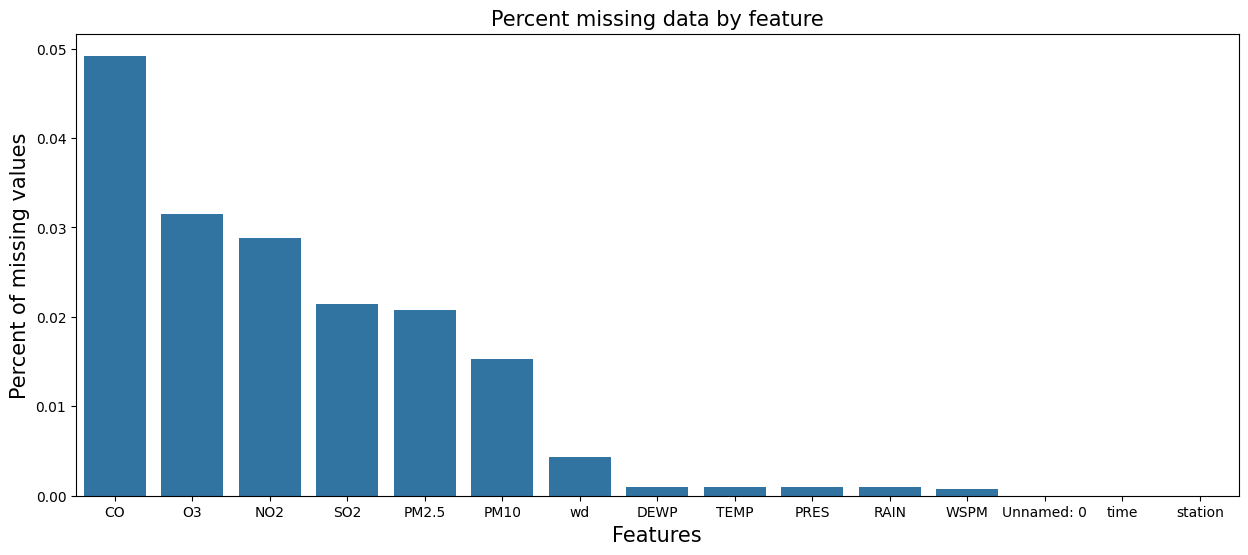

In [28]:
print("Tỷ lệ dữ liệu bị khuyết trong tập dataset trước khi tiền xử lý là: ",missing_rate(dataset),"%")
display_missing_percent(dataset)

In [29]:
print(get_stat_by_station(dataset))

+-----+---------------+----------+---------------------+---------------------+
| No. |    station    | #Records |      From date      |       To date       |
+-----+---------------+----------+---------------------+---------------------+
|  1  |  Aotizhongxin |  35,064  | 03-01-2013 00:00:00 | 02-12-2017 23:00:00 |
|  2  |   Changping   |  35,064  | 03-01-2013 00:00:00 | 02-12-2017 23:00:00 |
|  3  |    Dingling   |  35,064  | 03-01-2013 00:00:00 | 02-12-2017 23:00:00 |
|  4  |     Dongsi    |  35,064  | 03-01-2013 00:00:00 | 02-12-2017 23:00:00 |
|  5  |    Guanyuan   |  35,064  | 03-01-2013 00:00:00 | 02-12-2017 23:00:00 |
|  6  |    Gucheng    |  35,064  | 03-01-2013 00:00:00 | 02-12-2017 23:00:00 |
|  7  |    Huairou    |  35,064  | 03-01-2013 00:00:00 | 02-12-2017 23:00:00 |
|  8  |  Nongzhanguan |  35,064  | 03-01-2013 00:00:00 | 02-12-2017 23:00:00 |
|  9  |     Shunyi    |  35,064  | 03-01-2013 00:00:00 | 02-12-2017 23:00:00 |
|  10 |    Tiantan    |  35,064  | 03-01-2013 00:00:

In [30]:
find_time_steps(dataset)

The cycle duration appears to be approximately 3600.0 seconds.
The time cycle appears to be 24 hours.
Station Aotizhongxin is missing the following hours:
Date 2013-06-01 is missing hours: ['00:00', '01:00', '02:00', '03:00', '04:00', '05:00', '06:00', '07:00', '08:00', '09:00', '10:00', '11:00', '12:00', '13:00', '14:00', '15:00', '16:00', '17:00', '18:00', '19:00', '20:00', '21:00', '22:00', '23:00']
Date 2017-11-27 is missing hours: ['00:00', '01:00', '02:00', '03:00', '04:00', '05:00', '06:00', '07:00', '08:00', '09:00', '10:00', '11:00', '12:00', '13:00', '14:00', '15:00', '16:00', '17:00', '18:00', '19:00', '20:00', '21:00', '22:00', '23:00']
Date 2017-05-05 is missing hours: ['00:00', '01:00', '02:00', '03:00', '04:00', '05:00', '06:00', '07:00', '08:00', '09:00', '10:00', '11:00', '12:00', '13:00', '14:00', '15:00', '16:00', '17:00', '18:00', '19:00', '20:00', '21:00', '22:00', '23:00']
Date 2017-07-29 is missing hours: ['00:00', '01:00', '02:00', '03:00', '04:00', '05:00', '06

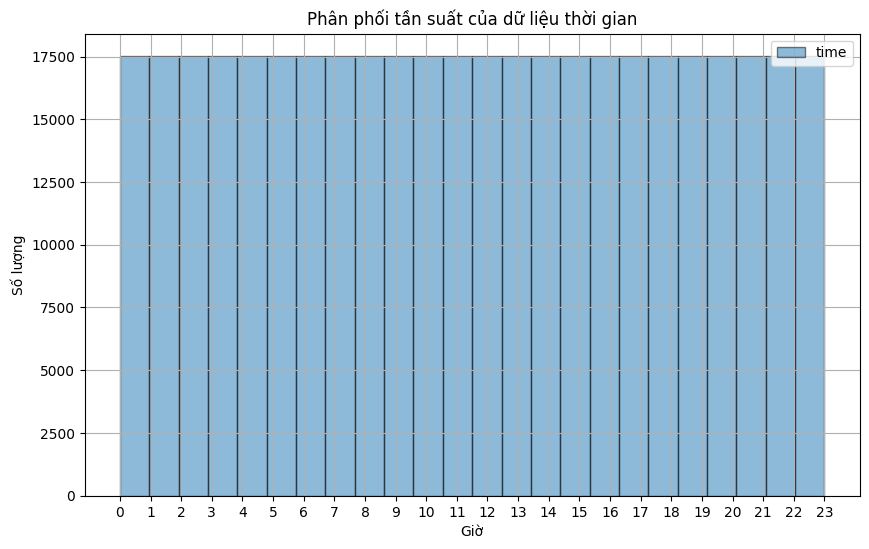

In [31]:
datasets=[(dataset,'time')]
timeGraph(datasets)

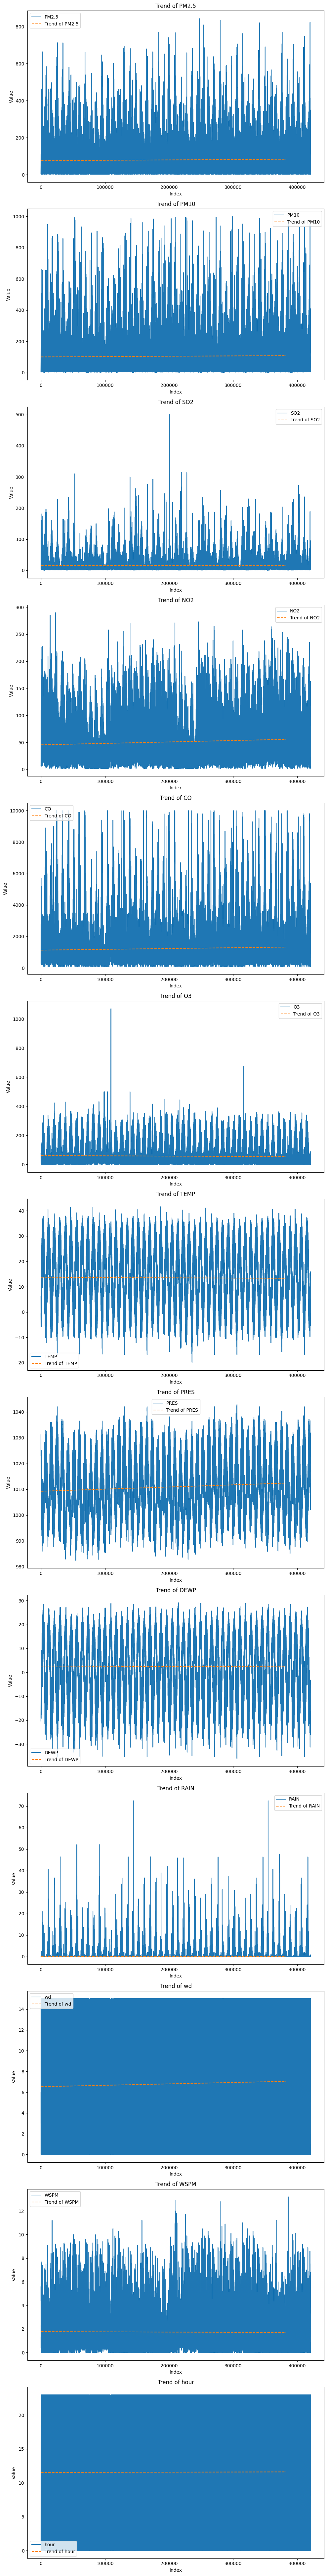

None


In [32]:
trend=calculate_trend(dataset)
print(trend)

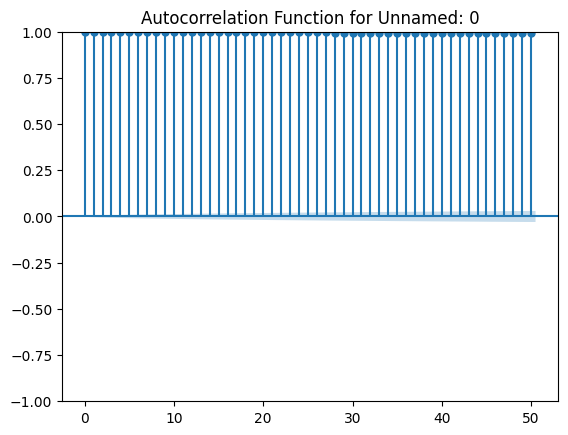

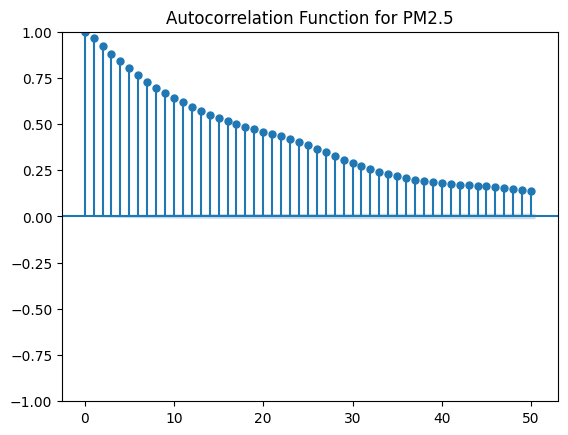

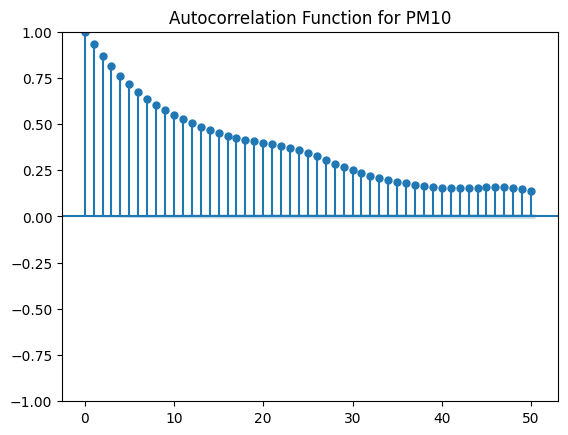

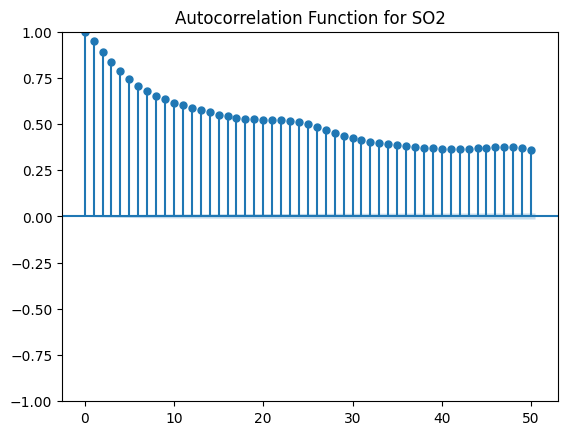

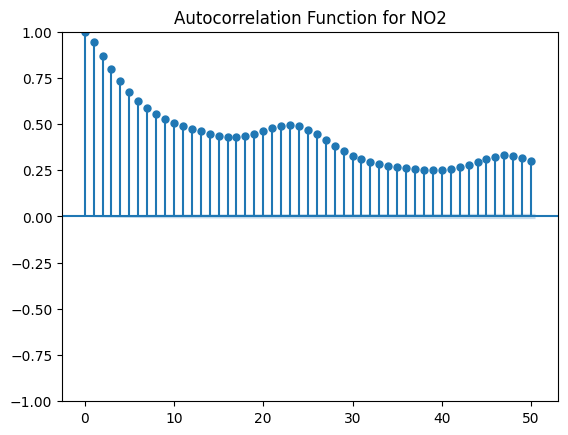

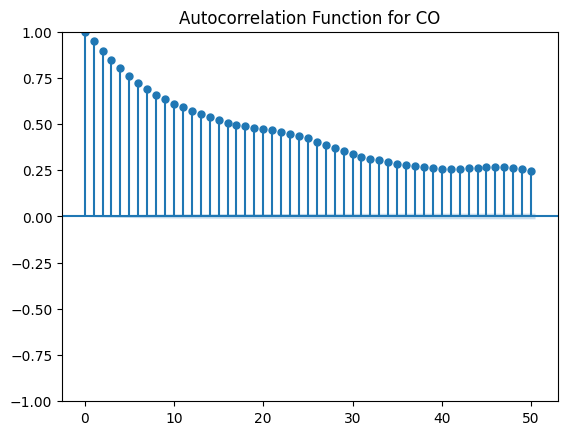

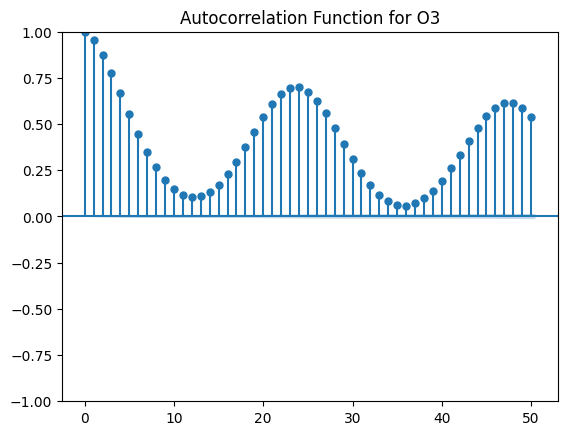

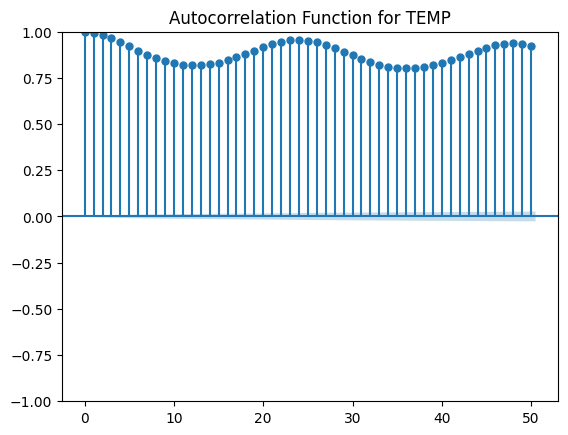

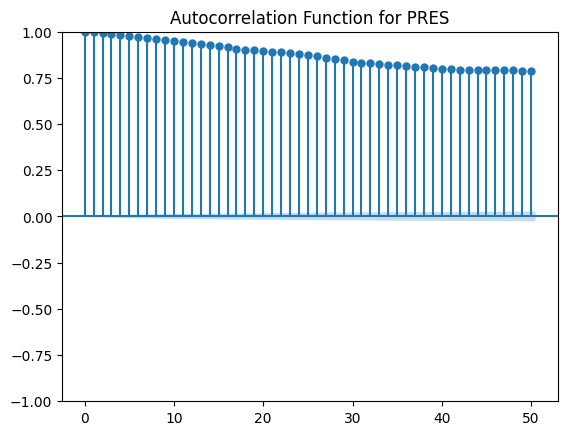

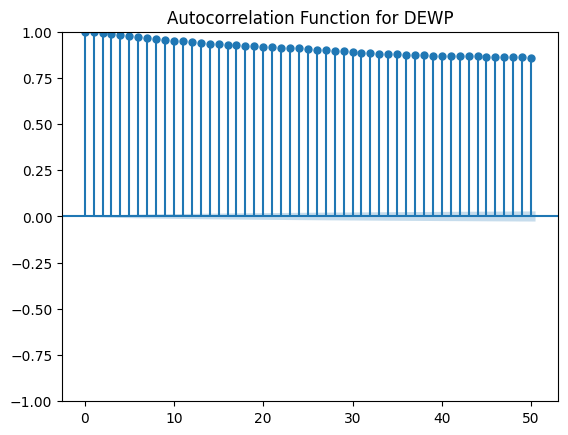

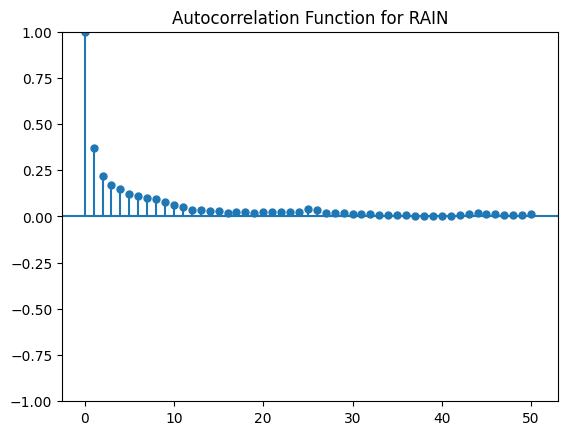

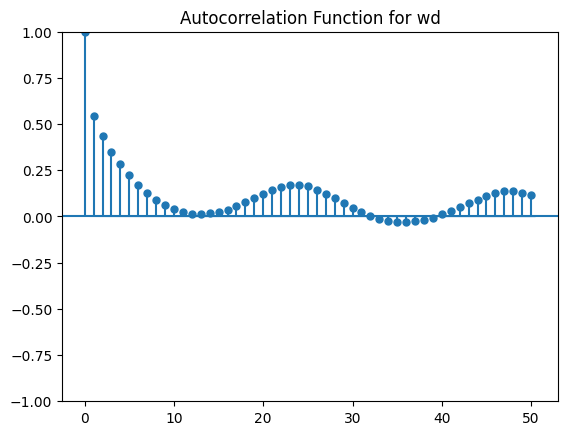

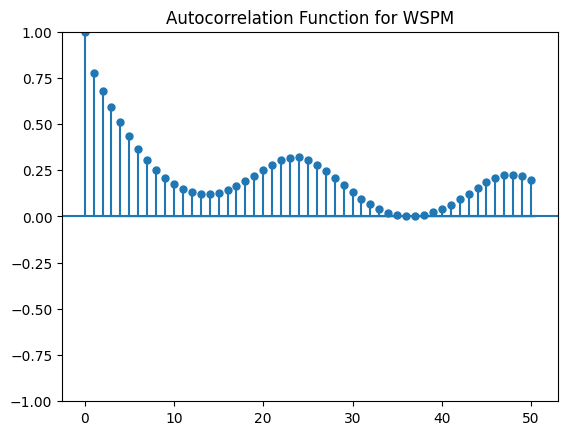

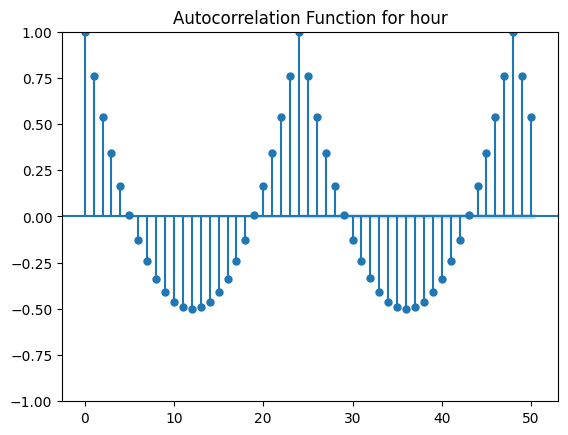

{'Unnamed: 0': 1,
 'PM2.5': 1,
 'PM10': 1,
 'SO2': 1,
 'NO2': 1,
 'CO': 1,
 'O3': 1,
 'TEMP': 1,
 'PRES': 1,
 'DEWP': 1,
 'RAIN': 1,
 'wd': 1,
 'WSPM': 1,
 'hour': 24}

In [33]:
find_cycles_for_all_columns(dataset)
# kết quả trả về cho thấy dữ liệu không có chu kỳ dài hạn rõ ràng trong phạm vi độ trễ được xem xét (ở đây là 50)

## Sau khi tiền xử lý

In [38]:
pre_dataset=preprocess_beijing(dataset)
print(pre_dataset)

Columns: Index(['Unnamed: 0', 'time', 'PM2.5', 'PM10', 'SO2', 'NO2', 'CO', 'O3', 'TEMP',
       'PRES', 'DEWP', 'RAIN', 'wd', 'WSPM', 'station', 'date', 'hour'],
      dtype='object')
X shape:  (516960, 17)
              station        date                time  Unnamed: 0  PM2.5  \
0        Aotizhongxin  2013-01-03 2013-01-03 00:00:00         0.0    4.0   
1        Aotizhongxin  2013-01-03 2013-01-03 01:00:00         1.0    8.0   
2        Aotizhongxin  2013-01-03 2013-01-03 02:00:00         2.0    7.0   
3        Aotizhongxin  2013-01-03 2013-01-03 03:00:00         3.0    6.0   
4        Aotizhongxin  2013-01-03 2013-01-03 04:00:00         4.0    3.0   
...               ...         ...                 ...         ...    ...   
516955  Wanshouxigong  2017-12-02 2017-12-02 19:00:00     34675.0  111.0   
516956  Wanshouxigong  2017-12-02 2017-12-02 20:00:00     34676.0  116.0   
516957  Wanshouxigong  2017-12-02 2017-12-02 21:00:00     34677.0  144.0   
516958  Wanshouxigong  2017-12-02

Tỷ lệ dữ liệu bị khuyết của tập dataset sau khi tiền xử lý là:  16.01 %


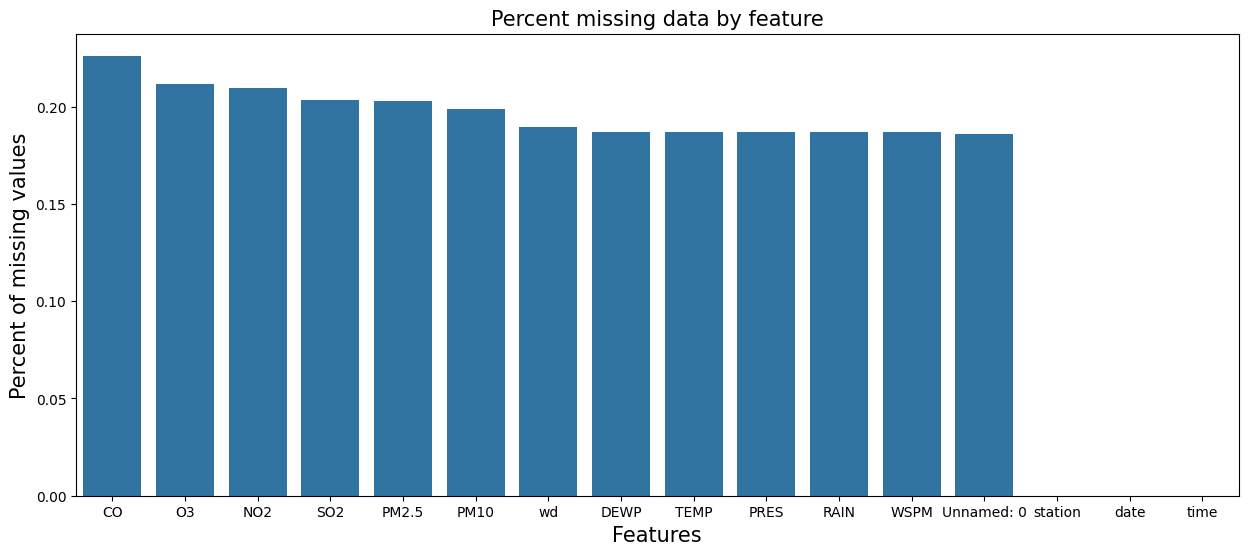

In [39]:
print("Tỷ lệ dữ liệu bị khuyết của tập dataset sau khi tiền xử lý là: ",missing_rate(pre_dataset),"%")
display_missing_percent(pre_dataset)

In [40]:
print(get_stat_by_station(pre_dataset))

+-----+---------------+----------+---------------------+---------------------+
| No. |    station    | #Records |      From date      |       To date       |
+-----+---------------+----------+---------------------+---------------------+
|  1  |  Aotizhongxin |  43,080  | 03-01-2013 00:00:00 | 02-12-2017 23:00:00 |
|  2  |   Changping   |  43,080  | 03-01-2013 00:00:00 | 02-12-2017 23:00:00 |
|  3  |    Dingling   |  43,080  | 03-01-2013 00:00:00 | 02-12-2017 23:00:00 |
|  4  |     Dongsi    |  43,080  | 03-01-2013 00:00:00 | 02-12-2017 23:00:00 |
|  5  |    Guanyuan   |  43,080  | 03-01-2013 00:00:00 | 02-12-2017 23:00:00 |
|  6  |    Gucheng    |  43,080  | 03-01-2013 00:00:00 | 02-12-2017 23:00:00 |
|  7  |    Huairou    |  43,080  | 03-01-2013 00:00:00 | 02-12-2017 23:00:00 |
|  8  |  Nongzhanguan |  43,080  | 03-01-2013 00:00:00 | 02-12-2017 23:00:00 |
|  9  |     Shunyi    |  43,080  | 03-01-2013 00:00:00 | 02-12-2017 23:00:00 |
|  10 |    Tiantan    |  43,080  | 03-01-2013 00:00:

In [41]:
find_time_steps(pre_dataset)

The cycle duration appears to be approximately 3600.0 seconds.
The time cycle appears to be 24 hours.
Station Aotizhongxin has no missing hours.
Station Changping has no missing hours.
Station Dingling has no missing hours.
Station Dongsi has no missing hours.
Station Guanyuan has no missing hours.
Station Gucheng has no missing hours.
Station Huairou has no missing hours.
Station Nongzhanguan has no missing hours.
Station Shunyi has no missing hours.
Station Tiantan has no missing hours.
Station Wanliu has no missing hours.
Station Wanshouxigong has no missing hours.


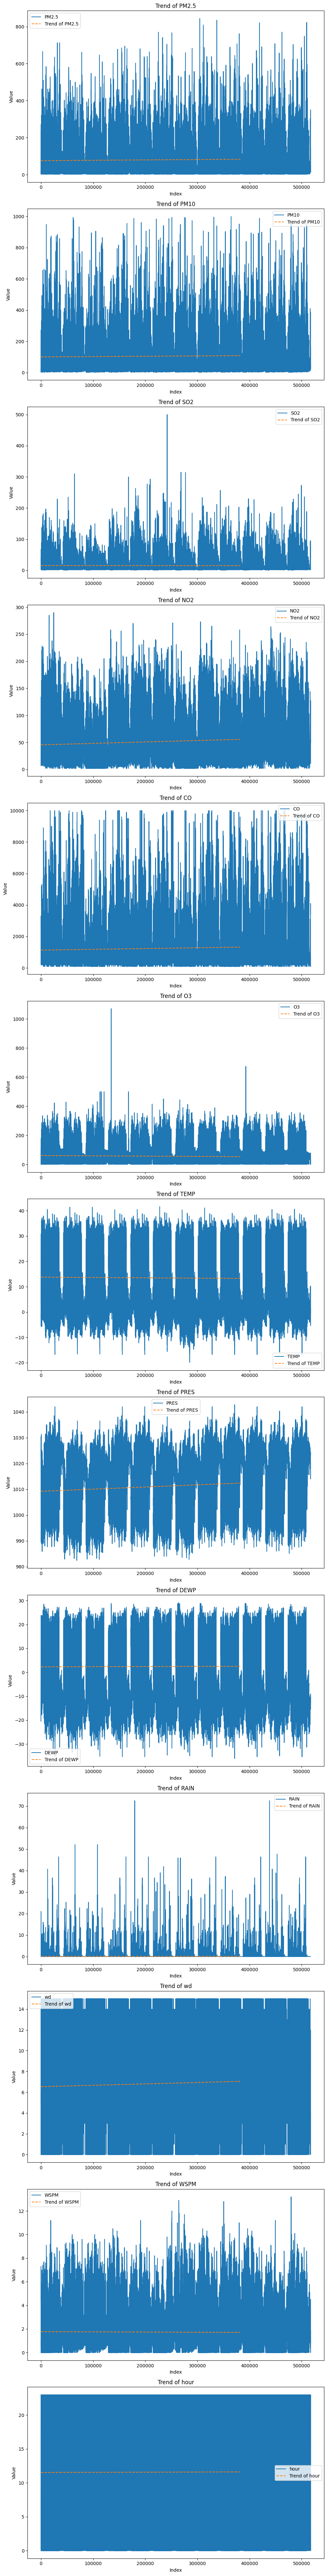

None


In [42]:
trends= calculate_trend(pre_dataset)
print(trend)

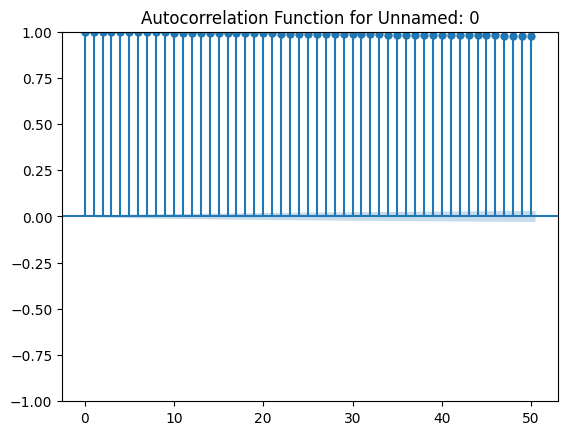

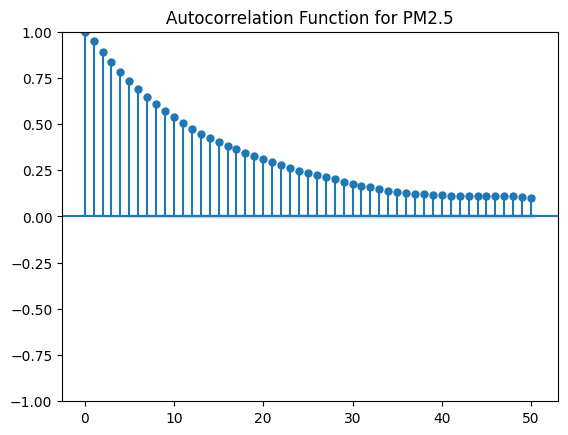

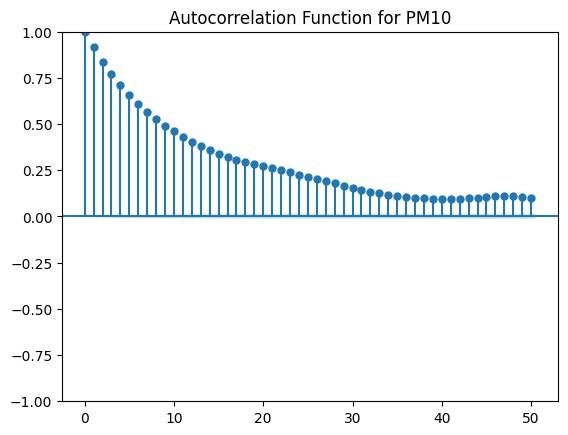

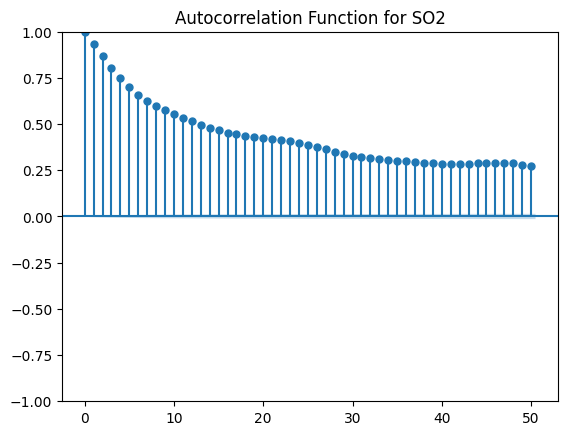

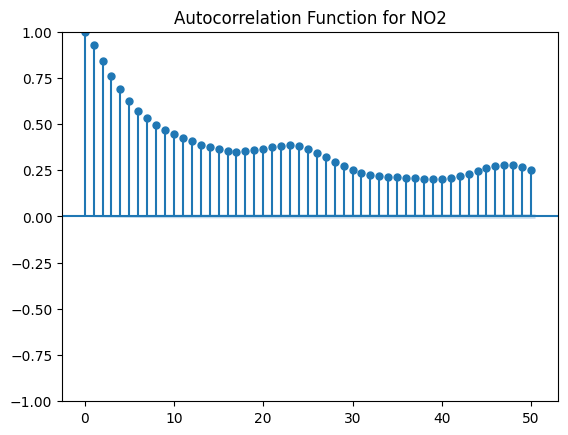

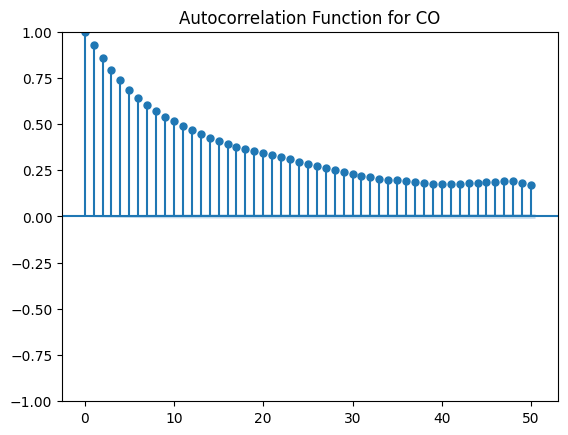

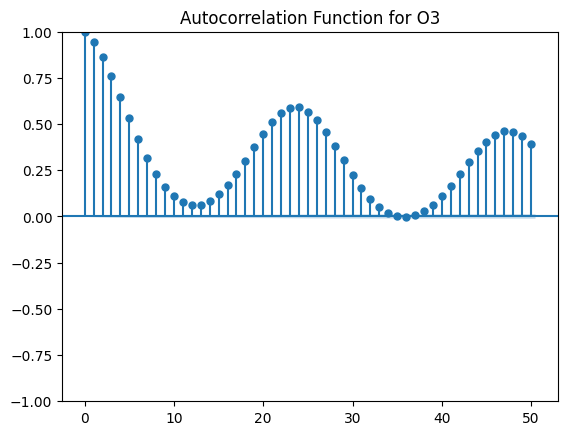

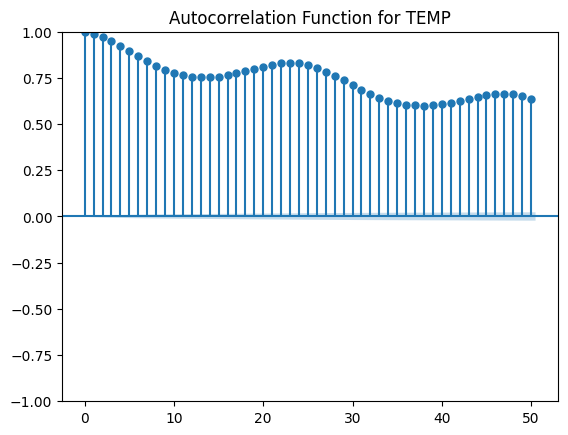

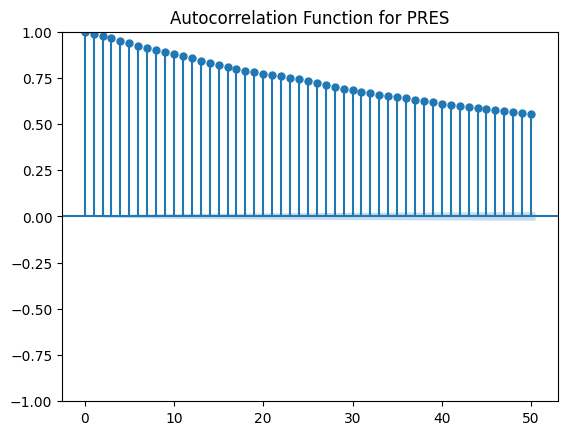

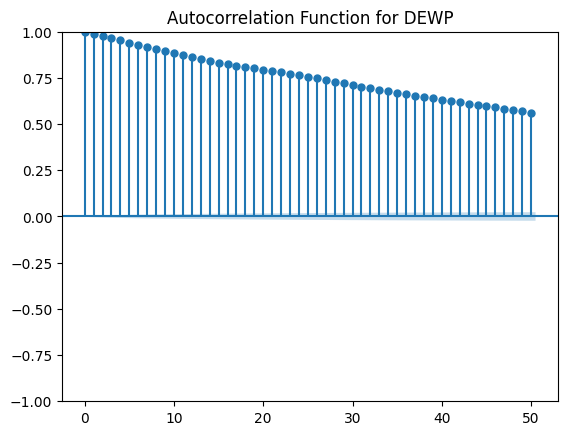

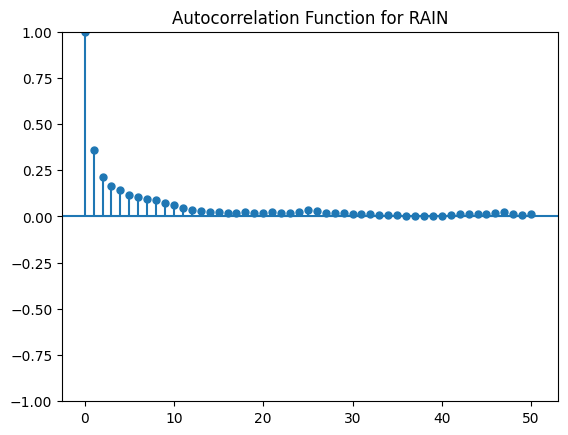

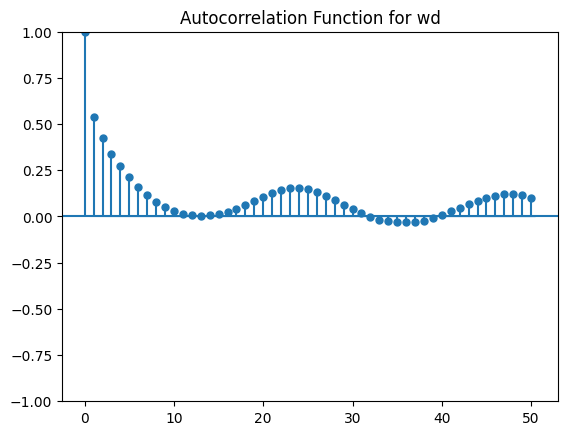

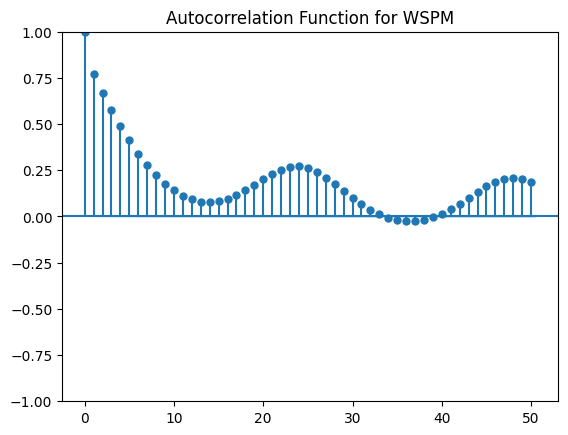

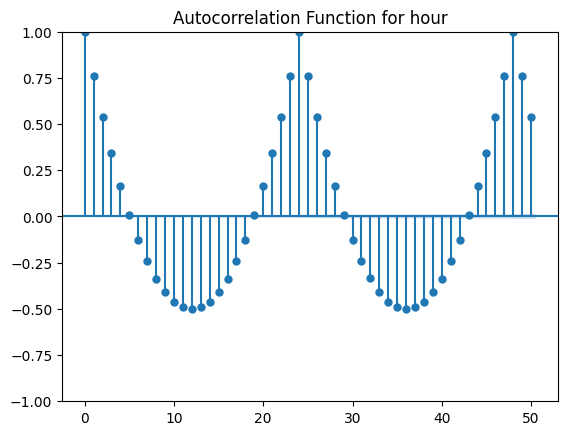

{'Unnamed: 0': 1,
 'PM2.5': 1,
 'PM10': 1,
 'SO2': 1,
 'NO2': 1,
 'CO': 1,
 'O3': 1,
 'TEMP': 1,
 'PRES': 1,
 'DEWP': 1,
 'RAIN': 1,
 'wd': 1,
 'WSPM': 1,
 'hour': 24}

In [43]:
find_cycles_for_all_columns(pre_dataset)

In [44]:
n_steps = 24
# missing_rates = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
missing_rates = [0.1]
methods = ['median','mean','knn', 'mice','saits','mrnn' ]



In [45]:
df_mae, df_mse, df_rmse, df_running_time = run_experiment(pre_dataset, missing_rates, methods)

Rate: 0.1 Method: median N: 0
Rate: 0.1 Method: median N: 1
Rate: 0.1 Method: median N: 2
Rate: 0.1 Method: median N: 3
Rate: 0.1 Method: median N: 4
Rate: 0.1 Method: median N: 5
Rate: 0.1 Method: median N: 6
Rate: 0.1 Method: median N: 7
Rate: 0.1 Method: median N: 8
Rate: 0.1 Method: median N: 9
Rate: 0.1 Method: mean N: 0
Rate: 0.1 Method: mean N: 1
Rate: 0.1 Method: mean N: 2
Rate: 0.1 Method: mean N: 3
Rate: 0.1 Method: mean N: 4
Rate: 0.1 Method: mean N: 5
Rate: 0.1 Method: mean N: 6
Rate: 0.1 Method: mean N: 7
Rate: 0.1 Method: mean N: 8
Rate: 0.1 Method: mean N: 9
Rate: 0.1 Method: knn N: 0
Rate: 0.1 Method: knn N: 1
Rate: 0.1 Method: knn N: 2
Rate: 0.1 Method: knn N: 3
Rate: 0.1 Method: knn N: 4
Rate: 0.1 Method: knn N: 5
Rate: 0.1 Method: knn N: 6
Rate: 0.1 Method: knn N: 7
Rate: 0.1 Method: knn N: 8
Rate: 0.1 Method: knn N: 9
Rate: 0.1 Method: mice N: 0
[IterativeImputer] Completing matrix with shape (9755, 336)
[IterativeImputer] Change: 0.0, scaled tolerance: 0.0848661450

2024-06-05 04:22:34 [INFO]: Using the given device: cpu
2024-06-05 04:22:34 [INFO]: Model files will be saved to data_beijing/saits/20240605_T042234
2024-06-05 04:22:34 [INFO]: Tensorboard file will be saved to data_beijing/saits/20240605_T042234/tensorboard
2024-06-05 04:22:35 [INFO]: SAITS initialized with the given hyperparameters, the number of trainable parameters: 1,339,152
2024-06-05 04:23:44 [INFO]: Epoch 001 - training loss: 0.6042, validation loss: 0.1344
2024-06-05 04:24:47 [INFO]: Epoch 002 - training loss: 0.4033, validation loss: 0.1336
2024-06-05 04:25:51 [INFO]: Epoch 003 - training loss: 0.3603, validation loss: 0.1212
2024-06-05 04:26:55 [INFO]: Epoch 004 - training loss: 0.3373, validation loss: 0.1240
2024-06-05 04:28:02 [INFO]: Epoch 005 - training loss: 0.3227, validation loss: 0.1162
2024-06-05 04:29:06 [INFO]: Epoch 006 - training loss: 0.3131, validation loss: 0.1142
2024-06-05 04:30:12 [INFO]: Epoch 007 - training loss: 0.3048, validation loss: 0.1250
2024-06-

Rate: 0.1 Method: saits N: 1


2024-06-05 04:36:01 [INFO]: Using the given device: cpu
2024-06-05 04:36:01 [INFO]: Model files will be saved to data_beijing/saits/20240605_T043601
2024-06-05 04:36:01 [INFO]: Tensorboard file will be saved to data_beijing/saits/20240605_T043601/tensorboard
2024-06-05 04:36:01 [INFO]: SAITS initialized with the given hyperparameters, the number of trainable parameters: 1,339,152
2024-06-05 04:37:08 [INFO]: Epoch 001 - training loss: 0.5890, validation loss: 0.1174
2024-06-05 04:38:14 [INFO]: Epoch 002 - training loss: 0.4113, validation loss: 0.1080
2024-06-05 04:39:22 [INFO]: Epoch 003 - training loss: 0.3610, validation loss: 0.1123
2024-06-05 04:40:27 [INFO]: Epoch 004 - training loss: 0.3332, validation loss: 0.1026
2024-06-05 04:41:31 [INFO]: Epoch 005 - training loss: 0.3163, validation loss: 0.1065
2024-06-05 04:42:38 [INFO]: Epoch 006 - training loss: 0.3052, validation loss: 0.1008
2024-06-05 04:43:42 [INFO]: Epoch 007 - training loss: 0.2987, validation loss: 0.0987
2024-06-

Rate: 0.1 Method: saits N: 2


2024-06-05 04:47:08 [INFO]: Using the given device: cpu
2024-06-05 04:47:08 [INFO]: Model files will be saved to data_beijing/saits/20240605_T044708
2024-06-05 04:47:08 [INFO]: Tensorboard file will be saved to data_beijing/saits/20240605_T044708/tensorboard
2024-06-05 04:47:08 [INFO]: SAITS initialized with the given hyperparameters, the number of trainable parameters: 1,339,152
2024-06-05 04:48:13 [INFO]: Epoch 001 - training loss: 0.6034, validation loss: 0.2016
2024-06-05 04:49:17 [INFO]: Epoch 002 - training loss: 0.3965, validation loss: 0.1928
2024-06-05 04:50:23 [INFO]: Epoch 003 - training loss: 0.3458, validation loss: 0.1902
2024-06-05 04:51:29 [INFO]: Epoch 004 - training loss: 0.3221, validation loss: 0.1873
2024-06-05 04:52:37 [INFO]: Epoch 005 - training loss: 0.3044, validation loss: 0.1864
2024-06-05 04:53:45 [INFO]: Epoch 006 - training loss: 0.2954, validation loss: 0.1870
2024-06-05 04:54:50 [INFO]: Epoch 007 - training loss: 0.2865, validation loss: 0.1866
2024-06-

Rate: 0.1 Method: saits N: 3


2024-06-05 05:03:53 [INFO]: SAITS initialized with the given hyperparameters, the number of trainable parameters: 1,339,152
2024-06-05 05:05:00 [INFO]: Epoch 001 - training loss: 0.6134, validation loss: 0.1236
2024-06-05 05:06:06 [INFO]: Epoch 002 - training loss: 0.3918, validation loss: 0.1152
2024-06-05 05:07:11 [INFO]: Epoch 003 - training loss: 0.3422, validation loss: 0.1101
2024-06-05 05:08:16 [INFO]: Epoch 004 - training loss: 0.3179, validation loss: 0.1002
2024-06-05 05:09:23 [INFO]: Epoch 005 - training loss: 0.3065, validation loss: 0.1027
2024-06-05 05:10:29 [INFO]: Epoch 006 - training loss: 0.2976, validation loss: 0.0993
2024-06-05 05:11:34 [INFO]: Epoch 007 - training loss: 0.2898, validation loss: 0.1126
2024-06-05 05:12:40 [INFO]: Epoch 008 - training loss: 0.2842, validation loss: 0.0992
2024-06-05 05:13:44 [INFO]: Epoch 009 - training loss: 0.2796, validation loss: 0.0937
2024-06-05 05:14:48 [INFO]: Epoch 010 - training loss: 0.2770, validation loss: 0.1024
2024-0

Rate: 0.1 Method: saits N: 4


2024-06-05 05:17:10 [INFO]: Model files will be saved to data_beijing/saits/20240605_T051710
2024-06-05 05:17:10 [INFO]: Tensorboard file will be saved to data_beijing/saits/20240605_T051710/tensorboard
2024-06-05 05:17:10 [INFO]: SAITS initialized with the given hyperparameters, the number of trainable parameters: 1,339,152
2024-06-05 05:18:13 [INFO]: Epoch 001 - training loss: 0.6051, validation loss: 0.1235
2024-06-05 05:19:18 [INFO]: Epoch 002 - training loss: 0.3885, validation loss: 0.1172
2024-06-05 05:20:25 [INFO]: Epoch 003 - training loss: 0.3471, validation loss: 0.1080
2024-06-05 05:21:30 [INFO]: Epoch 004 - training loss: 0.3235, validation loss: 0.1088
2024-06-05 05:22:35 [INFO]: Epoch 005 - training loss: 0.3075, validation loss: 0.1084
2024-06-05 05:23:37 [INFO]: Epoch 006 - training loss: 0.2956, validation loss: 0.1064
2024-06-05 05:24:43 [INFO]: Epoch 007 - training loss: 0.2884, validation loss: 0.1097
2024-06-05 05:25:48 [INFO]: Epoch 008 - training loss: 0.2825, v

Rate: 0.1 Method: saits N: 5


2024-06-05 05:27:02 [INFO]: Model files will be saved to data_beijing/saits/20240605_T052702
2024-06-05 05:27:02 [INFO]: Tensorboard file will be saved to data_beijing/saits/20240605_T052702/tensorboard
2024-06-05 05:27:02 [INFO]: SAITS initialized with the given hyperparameters, the number of trainable parameters: 1,339,152
2024-06-05 05:28:05 [INFO]: Epoch 001 - training loss: 0.5930, validation loss: 0.1513
2024-06-05 05:29:12 [INFO]: Epoch 002 - training loss: 0.3717, validation loss: 0.1341
2024-06-05 05:30:17 [INFO]: Epoch 003 - training loss: 0.3352, validation loss: 0.1393
2024-06-05 05:31:23 [INFO]: Epoch 004 - training loss: 0.3143, validation loss: 0.1296
2024-06-05 05:32:29 [INFO]: Epoch 005 - training loss: 0.3029, validation loss: 0.1259
2024-06-05 05:33:33 [INFO]: Epoch 006 - training loss: 0.2929, validation loss: 0.1369
2024-06-05 05:34:37 [INFO]: Epoch 007 - training loss: 0.2868, validation loss: 0.1292
2024-06-05 05:35:40 [INFO]: Epoch 008 - training loss: 0.2832, v

Rate: 0.1 Method: saits N: 6


2024-06-05 05:43:24 [INFO]: Using the given device: cpu
2024-06-05 05:43:24 [INFO]: Model files will be saved to data_beijing/saits/20240605_T054324
2024-06-05 05:43:24 [INFO]: Tensorboard file will be saved to data_beijing/saits/20240605_T054324/tensorboard
2024-06-05 05:43:24 [INFO]: SAITS initialized with the given hyperparameters, the number of trainable parameters: 1,339,152
2024-06-05 05:44:29 [INFO]: Epoch 001 - training loss: 0.5962, validation loss: 0.1174
2024-06-05 05:45:33 [INFO]: Epoch 002 - training loss: 0.4047, validation loss: 0.1107
2024-06-05 05:46:36 [INFO]: Epoch 003 - training loss: 0.3602, validation loss: 0.1055
2024-06-05 05:47:39 [INFO]: Epoch 004 - training loss: 0.3328, validation loss: 0.1022
2024-06-05 05:48:45 [INFO]: Epoch 005 - training loss: 0.3173, validation loss: 0.1012
2024-06-05 05:49:50 [INFO]: Epoch 006 - training loss: 0.3054, validation loss: 0.0979
2024-06-05 05:50:53 [INFO]: Epoch 007 - training loss: 0.2972, validation loss: 0.0971
2024-06-

Rate: 0.1 Method: saits N: 7


2024-06-05 05:59:32 [INFO]: SAITS initialized with the given hyperparameters, the number of trainable parameters: 1,339,152
2024-06-05 06:00:35 [INFO]: Epoch 001 - training loss: 0.6442, validation loss: 0.1635
2024-06-05 06:01:40 [INFO]: Epoch 002 - training loss: 0.4263, validation loss: 0.1501
2024-06-05 06:02:44 [INFO]: Epoch 003 - training loss: 0.3611, validation loss: 0.1359
2024-06-05 06:03:47 [INFO]: Epoch 004 - training loss: 0.3301, validation loss: 0.1346
2024-06-05 06:04:51 [INFO]: Epoch 005 - training loss: 0.3144, validation loss: 0.1362
2024-06-05 06:05:56 [INFO]: Epoch 006 - training loss: 0.3033, validation loss: 0.1280
2024-06-05 06:06:59 [INFO]: Epoch 007 - training loss: 0.2928, validation loss: 0.1288
2024-06-05 06:08:02 [INFO]: Epoch 008 - training loss: 0.2873, validation loss: 0.1308
2024-06-05 06:09:05 [INFO]: Epoch 009 - training loss: 0.2822, validation loss: 0.1228
2024-06-05 06:10:11 [INFO]: Epoch 010 - training loss: 0.2792, validation loss: 0.1227
2024-0

Rate: 0.1 Method: saits N: 8


2024-06-05 06:15:42 [INFO]: Model files will be saved to data_beijing/saits/20240605_T061542
2024-06-05 06:15:42 [INFO]: Tensorboard file will be saved to data_beijing/saits/20240605_T061542/tensorboard
2024-06-05 06:15:42 [INFO]: SAITS initialized with the given hyperparameters, the number of trainable parameters: 1,339,152
2024-06-05 06:16:44 [INFO]: Epoch 001 - training loss: 0.6384, validation loss: 0.1214
2024-06-05 06:17:47 [INFO]: Epoch 002 - training loss: 0.4040, validation loss: 0.1052
2024-06-05 06:18:51 [INFO]: Epoch 003 - training loss: 0.3543, validation loss: 0.1087
2024-06-05 06:19:55 [INFO]: Epoch 004 - training loss: 0.3298, validation loss: 0.1021
2024-06-05 06:20:58 [INFO]: Epoch 005 - training loss: 0.3159, validation loss: 0.1023
2024-06-05 06:22:01 [INFO]: Epoch 006 - training loss: 0.3061, validation loss: 0.0982
2024-06-05 06:23:07 [INFO]: Epoch 007 - training loss: 0.2975, validation loss: 0.0944
2024-06-05 06:24:10 [INFO]: Epoch 008 - training loss: 0.2915, v

Rate: 0.1 Method: saits N: 9


2024-06-05 06:26:28 [INFO]: SAITS initialized with the given hyperparameters, the number of trainable parameters: 1,339,152
2024-06-05 06:27:33 [INFO]: Epoch 001 - training loss: 0.5957, validation loss: 0.1245
2024-06-05 06:28:36 [INFO]: Epoch 002 - training loss: 0.4101, validation loss: 0.1110
2024-06-05 06:29:40 [INFO]: Epoch 003 - training loss: 0.3673, validation loss: 0.1041
2024-06-05 06:30:44 [INFO]: Epoch 004 - training loss: 0.3354, validation loss: 0.1052
2024-06-05 06:31:48 [INFO]: Epoch 005 - training loss: 0.3179, validation loss: 0.1012
2024-06-05 06:32:55 [INFO]: Epoch 006 - training loss: 0.3096, validation loss: 0.0969
2024-06-05 06:33:59 [INFO]: Epoch 007 - training loss: 0.3002, validation loss: 0.0994
2024-06-05 06:35:02 [INFO]: Epoch 008 - training loss: 0.2949, validation loss: 0.0974
2024-06-05 06:36:07 [INFO]: Epoch 009 - training loss: 0.2878, validation loss: 0.1012
2024-06-05 06:36:07 [INFO]: Exceeded the training patience. Terminating the training procedur

Rate: 0.1 Method: mrnn N: 0


2024-06-05 06:36:18 [INFO]: Model files will be saved to data_beijing/mrnn/20240605_T063618
2024-06-05 06:36:18 [INFO]: Tensorboard file will be saved to data_beijing/mrnn/20240605_T063618/tensorboard
2024-06-05 06:36:18 [INFO]: MRNN initialized with the given hyperparameters, the number of trainable parameters: 103,213
2024-06-05 06:39:24 [INFO]: Epoch 001 - training loss: 1.1869, validation loss: 0.8493
2024-06-05 06:42:15 [INFO]: Epoch 002 - training loss: 0.9971, validation loss: 0.8038
2024-06-05 06:45:01 [INFO]: Epoch 003 - training loss: 0.9478, validation loss: 0.7747
2024-06-05 06:47:49 [INFO]: Epoch 004 - training loss: 0.9125, validation loss: 0.7515
2024-06-05 06:50:36 [INFO]: Epoch 005 - training loss: 0.8898, validation loss: 0.7411
2024-06-05 06:53:17 [INFO]: Epoch 006 - training loss: 0.8702, validation loss: 0.7346
2024-06-05 06:56:05 [INFO]: Epoch 007 - training loss: 0.8530, validation loss: 0.7312
2024-06-05 06:58:51 [INFO]: Epoch 008 - training loss: 0.8403, valida

Rate: 0.1 Method: mrnn N: 1


2024-06-05 07:10:36 [INFO]: Tensorboard file will be saved to data_beijing/mrnn/20240605_T071036/tensorboard
2024-06-05 07:10:36 [INFO]: MRNN initialized with the given hyperparameters, the number of trainable parameters: 103,213
2024-06-05 07:13:43 [INFO]: Epoch 001 - training loss: 1.1830, validation loss: 0.8281
2024-06-05 07:16:33 [INFO]: Epoch 002 - training loss: 0.9939, validation loss: 0.7786
2024-06-05 07:19:25 [INFO]: Epoch 003 - training loss: 0.9389, validation loss: 0.7496
2024-06-05 07:22:16 [INFO]: Epoch 004 - training loss: 0.9105, validation loss: 0.7349
2024-06-05 07:25:07 [INFO]: Epoch 005 - training loss: 0.8889, validation loss: 0.7234
2024-06-05 07:27:59 [INFO]: Epoch 006 - training loss: 0.8676, validation loss: 0.7153
2024-06-05 07:30:48 [INFO]: Epoch 007 - training loss: 0.8496, validation loss: 0.7105
2024-06-05 07:33:41 [INFO]: Epoch 008 - training loss: 0.8398, validation loss: 0.7069
2024-06-05 07:36:32 [INFO]: Epoch 009 - training loss: 0.8302, validation 

Rate: 0.1 Method: mrnn N: 2


2024-06-05 07:51:09 [INFO]: Model files will be saved to data_beijing/mrnn/20240605_T075109
2024-06-05 07:51:09 [INFO]: Tensorboard file will be saved to data_beijing/mrnn/20240605_T075109/tensorboard
2024-06-05 07:51:09 [INFO]: MRNN initialized with the given hyperparameters, the number of trainable parameters: 103,213
2024-06-05 07:54:13 [INFO]: Epoch 001 - training loss: 1.1847, validation loss: 0.8020
2024-06-05 07:57:02 [INFO]: Epoch 002 - training loss: 1.0051, validation loss: 0.7714
2024-06-05 07:59:49 [INFO]: Epoch 003 - training loss: 0.9532, validation loss: 0.7471
2024-06-05 08:02:37 [INFO]: Epoch 004 - training loss: 0.9202, validation loss: 0.7313
2024-06-05 08:05:24 [INFO]: Epoch 005 - training loss: 0.8951, validation loss: 0.7184
2024-06-05 08:08:14 [INFO]: Epoch 006 - training loss: 0.8721, validation loss: 0.7044
2024-06-05 08:11:02 [INFO]: Epoch 007 - training loss: 0.8545, validation loss: 0.6962
2024-06-05 08:13:48 [INFO]: Epoch 008 - training loss: 0.8431, valida

Rate: 0.1 Method: mrnn N: 3


2024-06-05 08:31:17 [INFO]: Using the given device: cpu
2024-06-05 08:31:17 [INFO]: Model files will be saved to data_beijing/mrnn/20240605_T083117
2024-06-05 08:31:17 [INFO]: Tensorboard file will be saved to data_beijing/mrnn/20240605_T083117/tensorboard
2024-06-05 08:31:17 [INFO]: MRNN initialized with the given hyperparameters, the number of trainable parameters: 103,213
2024-06-05 08:34:23 [INFO]: Epoch 001 - training loss: 1.1896, validation loss: 0.8256
2024-06-05 08:37:13 [INFO]: Epoch 002 - training loss: 1.0039, validation loss: 0.7873
2024-06-05 08:40:05 [INFO]: Epoch 003 - training loss: 0.9524, validation loss: 0.7589
2024-06-05 08:42:52 [INFO]: Epoch 004 - training loss: 0.9179, validation loss: 0.7338
2024-06-05 08:45:42 [INFO]: Epoch 005 - training loss: 0.8920, validation loss: 0.7154
2024-06-05 08:48:30 [INFO]: Epoch 006 - training loss: 0.8682, validation loss: 0.7102
2024-06-05 08:51:21 [INFO]: Epoch 007 - training loss: 0.8520, validation loss: 0.7063
2024-06-05 08

Rate: 0.1 Method: mrnn N: 4


2024-06-05 09:03:11 [INFO]: Using the given device: cpu
2024-06-05 09:03:11 [INFO]: Model files will be saved to data_beijing/mrnn/20240605_T090311
2024-06-05 09:03:11 [INFO]: Tensorboard file will be saved to data_beijing/mrnn/20240605_T090311/tensorboard
2024-06-05 09:03:11 [INFO]: MRNN initialized with the given hyperparameters, the number of trainable parameters: 103,213
2024-06-05 09:06:17 [INFO]: Epoch 001 - training loss: 1.1764, validation loss: 0.8119
2024-06-05 09:09:09 [INFO]: Epoch 002 - training loss: 0.9906, validation loss: 0.7681
2024-06-05 09:11:57 [INFO]: Epoch 003 - training loss: 0.9405, validation loss: 0.7413
2024-06-05 09:14:47 [INFO]: Epoch 004 - training loss: 0.9099, validation loss: 0.7276
2024-06-05 09:17:36 [INFO]: Epoch 005 - training loss: 0.8868, validation loss: 0.7140
2024-06-05 09:20:30 [INFO]: Epoch 006 - training loss: 0.8620, validation loss: 0.7008
2024-06-05 09:23:25 [INFO]: Epoch 007 - training loss: 0.8505, validation loss: 0.6938
2024-06-05 09

Rate: 0.1 Method: mrnn N: 5


2024-06-05 09:38:42 [INFO]: MRNN initialized with the given hyperparameters, the number of trainable parameters: 103,213
2024-06-05 09:41:46 [INFO]: Epoch 001 - training loss: 1.1795, validation loss: 0.8445
2024-06-05 09:44:39 [INFO]: Epoch 002 - training loss: 1.0065, validation loss: 0.7934
2024-06-05 09:47:33 [INFO]: Epoch 003 - training loss: 0.9474, validation loss: 0.7590
2024-06-05 09:50:27 [INFO]: Epoch 004 - training loss: 0.9132, validation loss: 0.7375
2024-06-05 09:53:20 [INFO]: Epoch 005 - training loss: 0.8910, validation loss: 0.7266
2024-06-05 09:56:17 [INFO]: Epoch 006 - training loss: 0.8668, validation loss: 0.7219
2024-06-05 09:59:10 [INFO]: Epoch 007 - training loss: 0.8521, validation loss: 0.7177
2024-06-05 10:02:05 [INFO]: Epoch 008 - training loss: 0.8387, validation loss: 0.7135
2024-06-05 10:05:00 [INFO]: Epoch 009 - training loss: 0.8272, validation loss: 0.7134
2024-06-05 10:07:57 [INFO]: Epoch 010 - training loss: 0.8187, validation loss: 0.7087
2024-06-0

Rate: 0.1 Method: mrnn N: 6


2024-06-05 10:17:23 [INFO]: Model files will be saved to data_beijing/mrnn/20240605_T101723
2024-06-05 10:17:23 [INFO]: Tensorboard file will be saved to data_beijing/mrnn/20240605_T101723/tensorboard
2024-06-05 10:17:24 [INFO]: MRNN initialized with the given hyperparameters, the number of trainable parameters: 103,213
2024-06-05 10:20:31 [INFO]: Epoch 001 - training loss: 1.1876, validation loss: 0.8209
2024-06-05 10:23:21 [INFO]: Epoch 002 - training loss: 1.0014, validation loss: 0.7781
2024-06-05 10:26:12 [INFO]: Epoch 003 - training loss: 0.9484, validation loss: 0.7459
2024-06-05 10:29:06 [INFO]: Epoch 004 - training loss: 0.9121, validation loss: 0.7274
2024-06-05 10:32:04 [INFO]: Epoch 005 - training loss: 0.8884, validation loss: 0.7139
2024-06-05 10:35:01 [INFO]: Epoch 006 - training loss: 0.8688, validation loss: 0.7074
2024-06-05 10:37:57 [INFO]: Epoch 007 - training loss: 0.8482, validation loss: 0.7009
2024-06-05 10:40:47 [INFO]: Epoch 008 - training loss: 0.8378, valida

Rate: 0.1 Method: mrnn N: 7


2024-06-05 10:55:50 [INFO]: Using the given device: cpu
2024-06-05 10:55:50 [INFO]: Model files will be saved to data_beijing/mrnn/20240605_T105550
2024-06-05 10:55:50 [INFO]: Tensorboard file will be saved to data_beijing/mrnn/20240605_T105550/tensorboard
2024-06-05 10:55:50 [INFO]: MRNN initialized with the given hyperparameters, the number of trainable parameters: 103,213
2024-06-05 10:58:58 [INFO]: Epoch 001 - training loss: 1.1852, validation loss: 0.8440
2024-06-05 11:01:51 [INFO]: Epoch 002 - training loss: 1.0047, validation loss: 0.8044
2024-06-05 11:04:46 [INFO]: Epoch 003 - training loss: 0.9482, validation loss: 0.7801
2024-06-05 11:07:42 [INFO]: Epoch 004 - training loss: 0.9161, validation loss: 0.7665
2024-06-05 11:10:36 [INFO]: Epoch 005 - training loss: 0.8943, validation loss: 0.7570
2024-06-05 11:13:34 [INFO]: Epoch 006 - training loss: 0.8754, validation loss: 0.7445
2024-06-05 11:16:30 [INFO]: Epoch 007 - training loss: 0.8568, validation loss: 0.7376
2024-06-05 11

Rate: 0.1 Method: mrnn N: 8


2024-06-05 11:31:47 [INFO]: Using the given device: cpu
2024-06-05 11:31:47 [INFO]: Model files will be saved to data_beijing/mrnn/20240605_T113147
2024-06-05 11:31:47 [INFO]: Tensorboard file will be saved to data_beijing/mrnn/20240605_T113147/tensorboard
2024-06-05 11:31:47 [INFO]: MRNN initialized with the given hyperparameters, the number of trainable parameters: 103,213
2024-06-05 11:35:45 [INFO]: Epoch 001 - training loss: 1.1845, validation loss: 0.8298
2024-06-05 11:38:42 [INFO]: Epoch 002 - training loss: 1.0031, validation loss: 0.7795
2024-06-05 11:41:40 [INFO]: Epoch 003 - training loss: 0.9494, validation loss: 0.7498
2024-06-05 11:44:34 [INFO]: Epoch 004 - training loss: 0.9161, validation loss: 0.7295
2024-06-05 11:47:30 [INFO]: Epoch 005 - training loss: 0.8905, validation loss: 0.7151
2024-06-05 11:50:27 [INFO]: Epoch 006 - training loss: 0.8676, validation loss: 0.7089
2024-06-05 11:53:22 [INFO]: Epoch 007 - training loss: 0.8535, validation loss: 0.7074
2024-06-05 11

Rate: 0.1 Method: mrnn N: 9


2024-06-05 12:05:37 [INFO]: Using the given device: cpu
2024-06-05 12:05:37 [INFO]: Model files will be saved to data_beijing/mrnn/20240605_T120537
2024-06-05 12:05:37 [INFO]: Tensorboard file will be saved to data_beijing/mrnn/20240605_T120537/tensorboard
2024-06-05 12:05:37 [INFO]: MRNN initialized with the given hyperparameters, the number of trainable parameters: 103,213
2024-06-05 12:08:48 [INFO]: Epoch 001 - training loss: 1.1839, validation loss: 0.8275
2024-06-05 12:11:43 [INFO]: Epoch 002 - training loss: 1.0074, validation loss: 0.7844
2024-06-05 12:14:38 [INFO]: Epoch 003 - training loss: 0.9497, validation loss: 0.7594
2024-06-05 12:17:32 [INFO]: Epoch 004 - training loss: 0.9153, validation loss: 0.7390
2024-06-05 12:20:21 [INFO]: Epoch 005 - training loss: 0.8890, validation loss: 0.7224
2024-06-05 12:23:11 [INFO]: Epoch 006 - training loss: 0.8683, validation loss: 0.7140
2024-06-05 12:26:00 [INFO]: Epoch 007 - training loss: 0.8505, validation loss: 0.7078
2024-06-05 12